In [1]:
from slf_dataset import SLFDataset1bit, DEFAULT_ROOT, SLFDataset
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy.io
import torch.nn as nn
import os
import sys
from networks.gan import Generator, Generator256, Generator512
from networks.ae import AutoencoderSelu
from networks.dip import DecoderDip

generator = Generator256()

SLF_ROOT = '/scratch/sagar/slf/train_set/set_harsh_torch_raw_unnormalized'

train_set_slf = SLFDataset(root_dir=os.path.join(SLF_ROOT, 'slf_mat'), 
                    csv_file=os.path.join(SLF_ROOT, 'details.csv'), total_data=10000, sample_size=[0.1, 0.11])




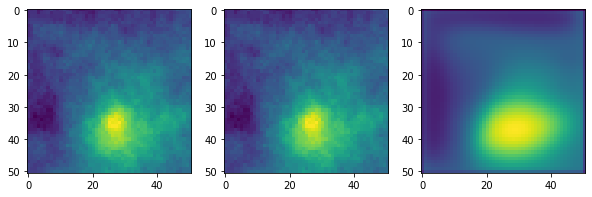

9950 0.046178802847862244 0.014513492584228516


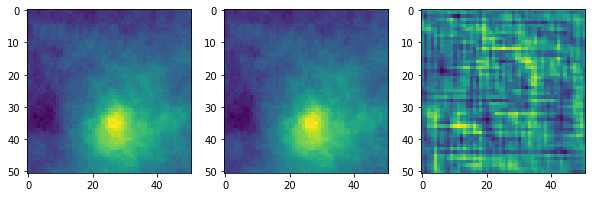

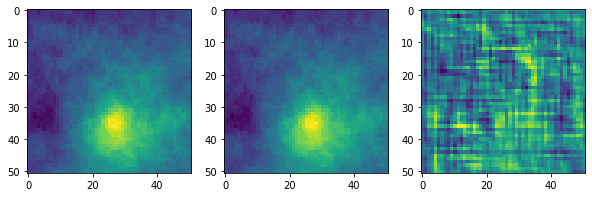

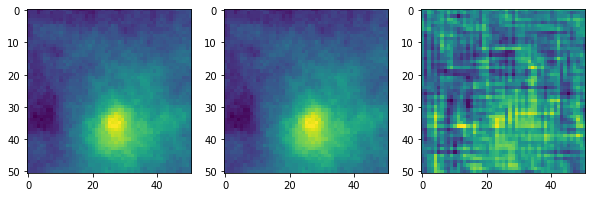

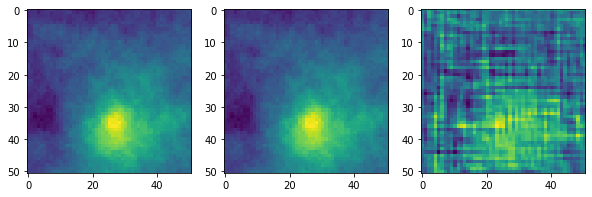

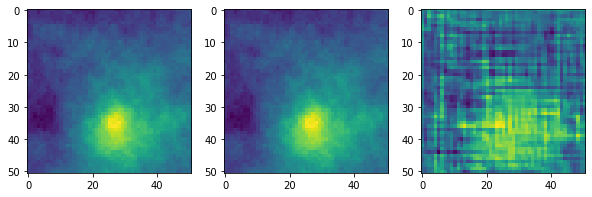

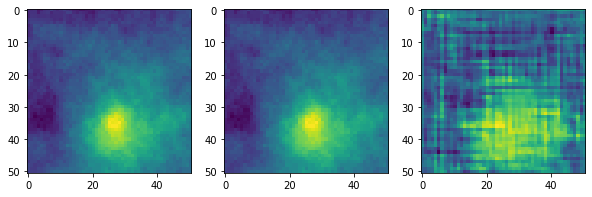

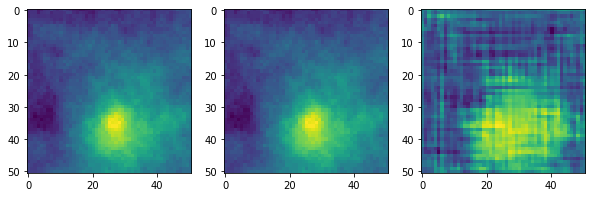

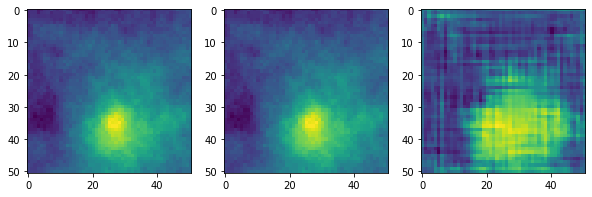

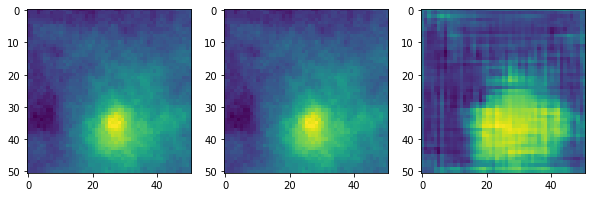

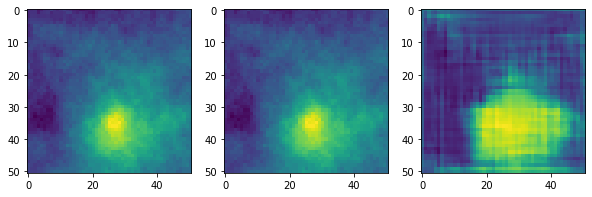

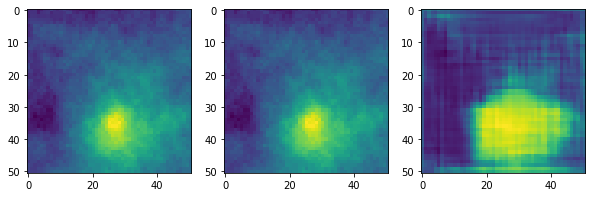

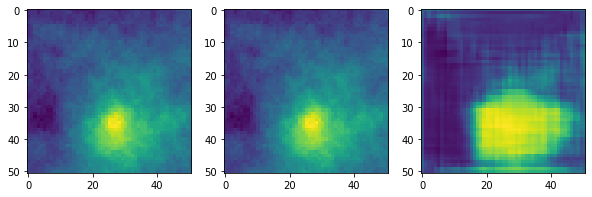

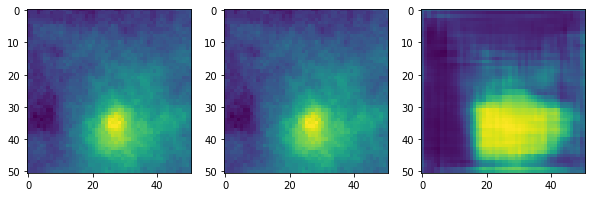

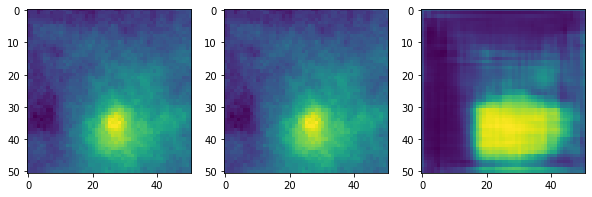

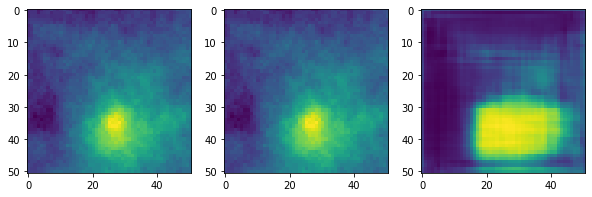

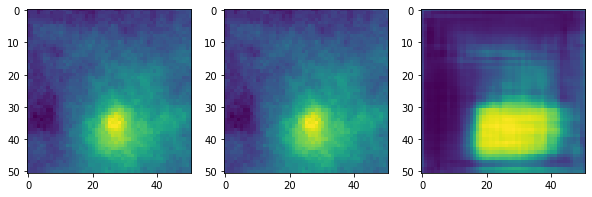

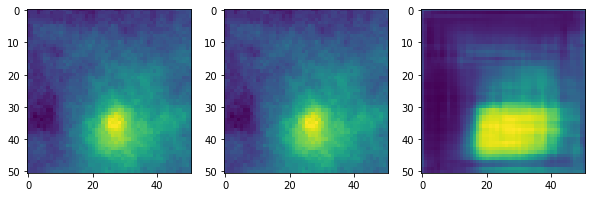

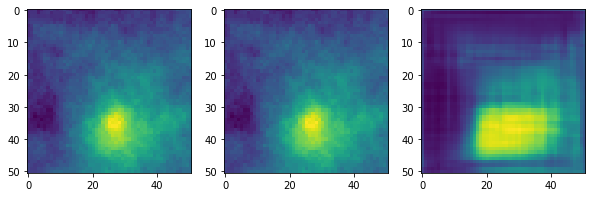

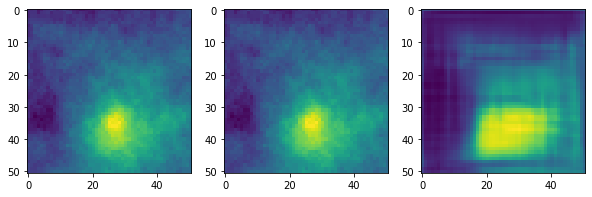

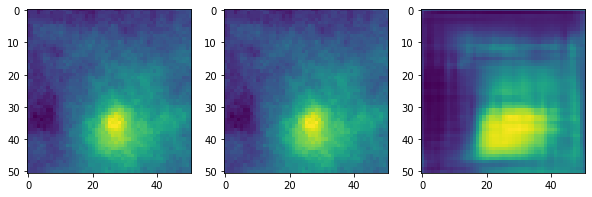

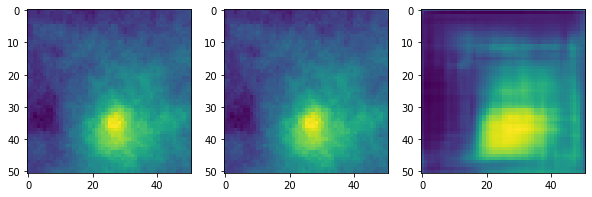

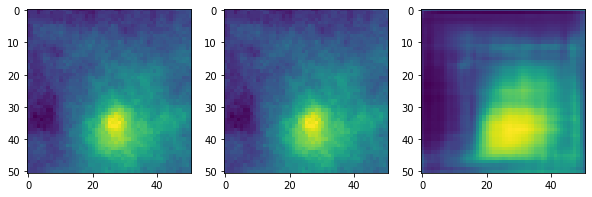

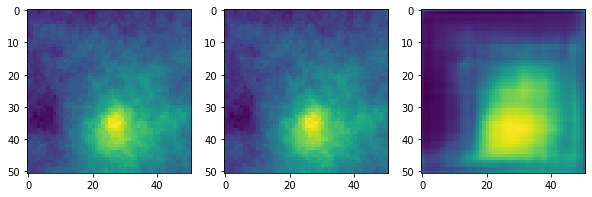

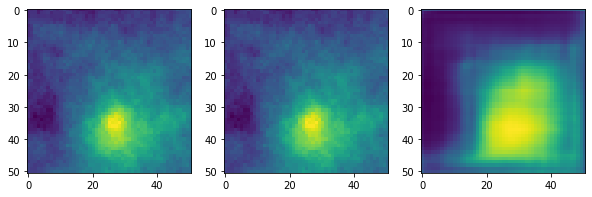

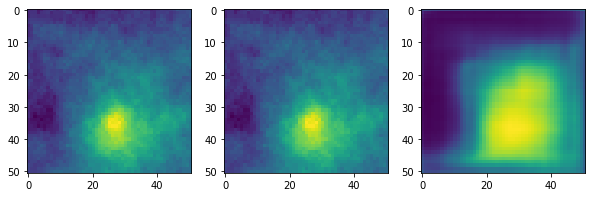

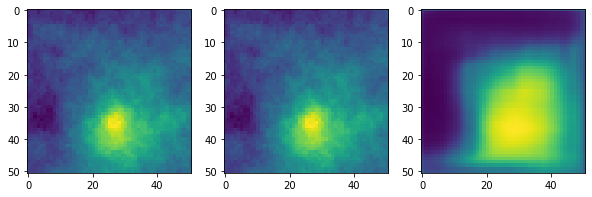

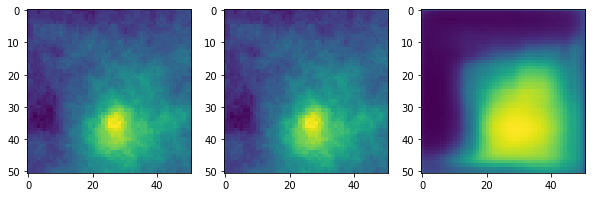

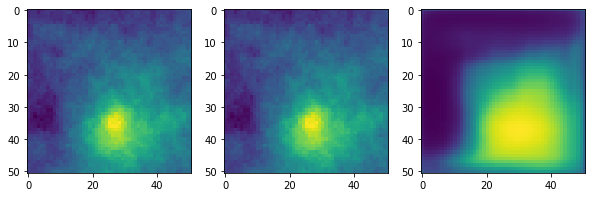

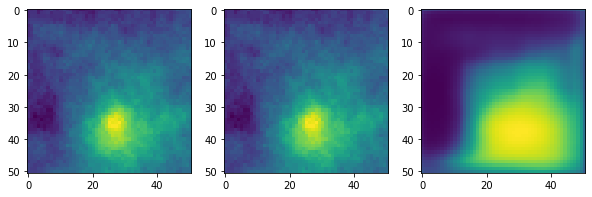

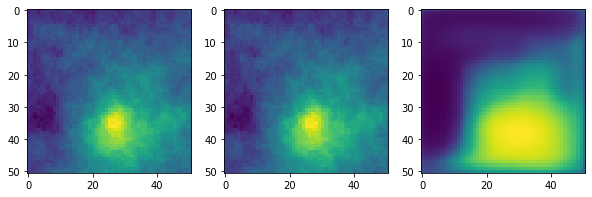

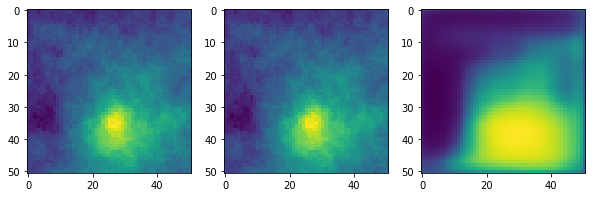

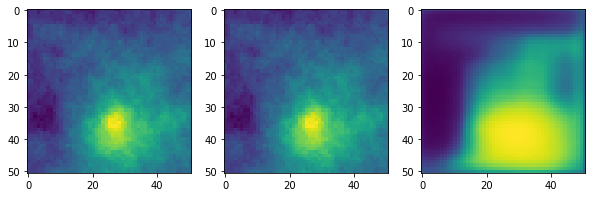

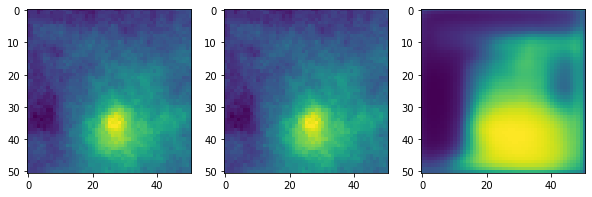

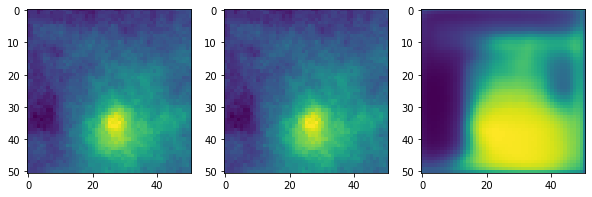

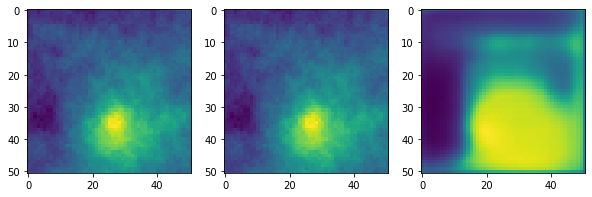

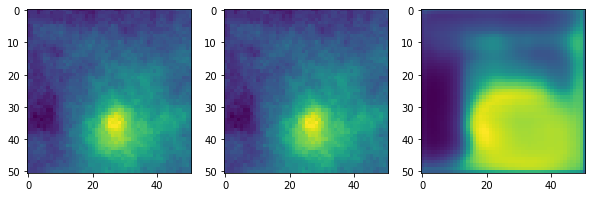

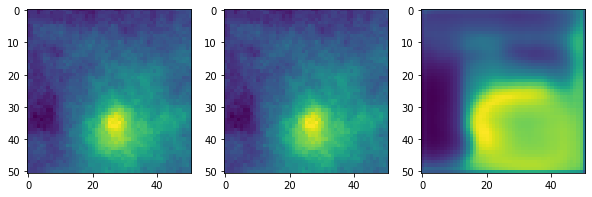

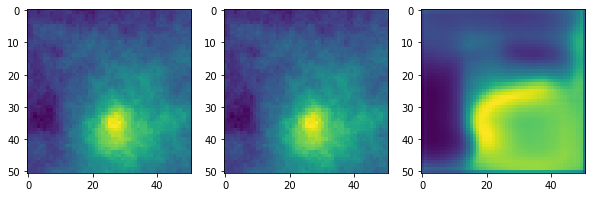

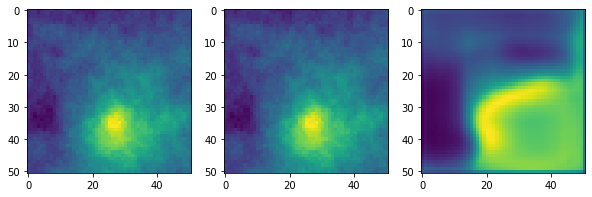

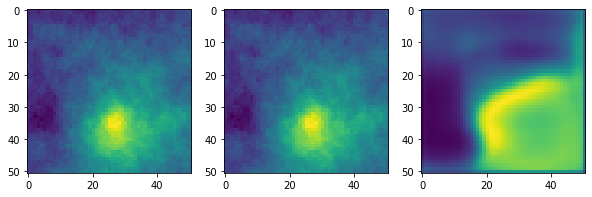

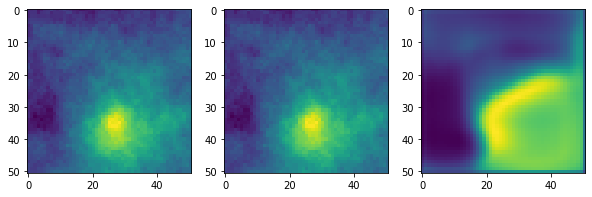

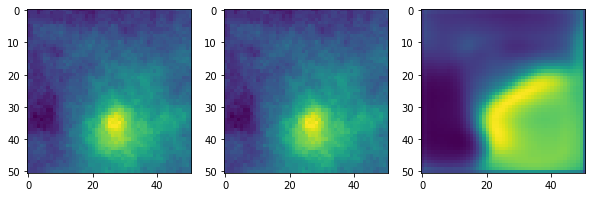

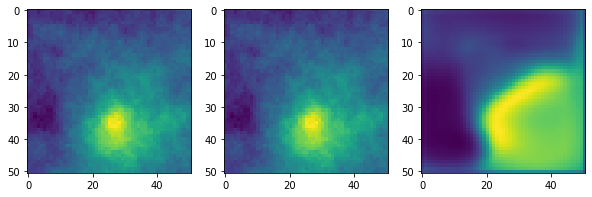

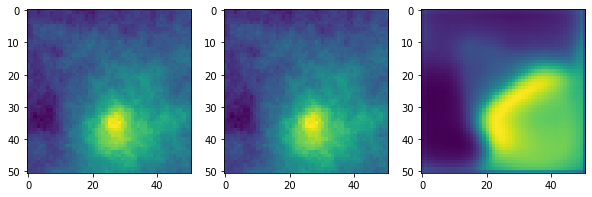

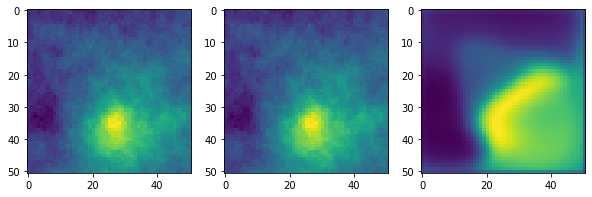

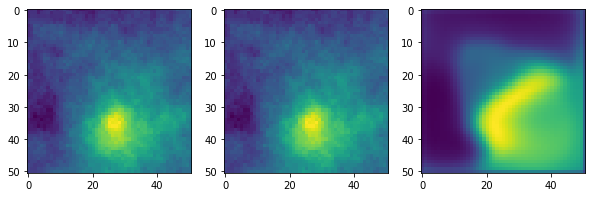

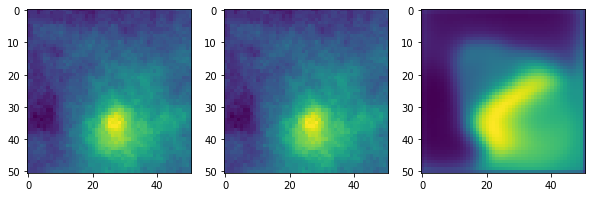

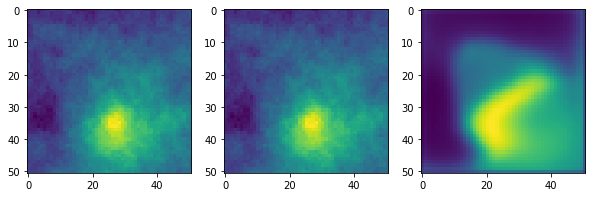

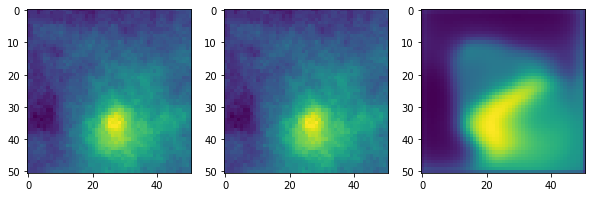

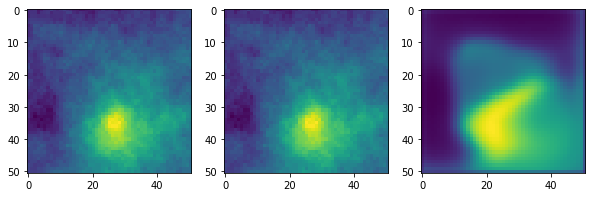

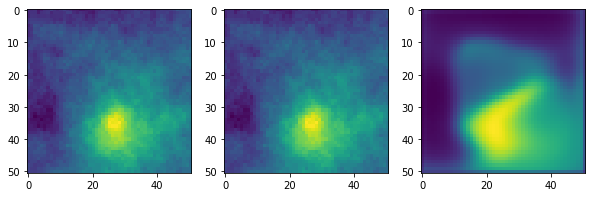

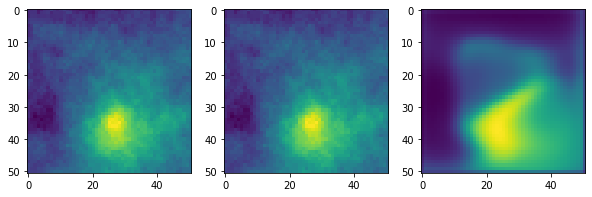

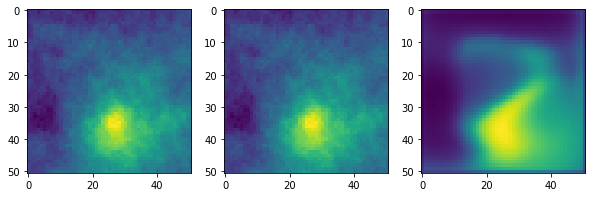

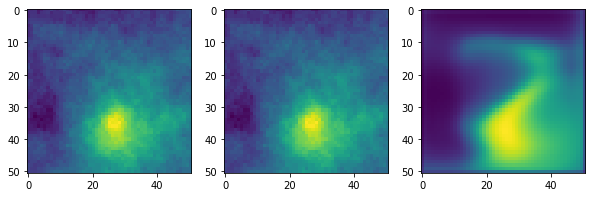

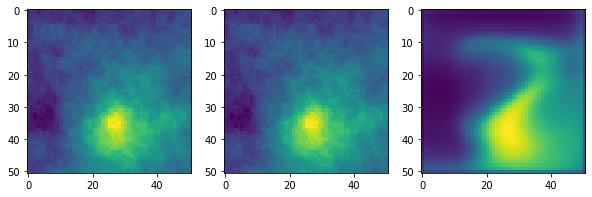

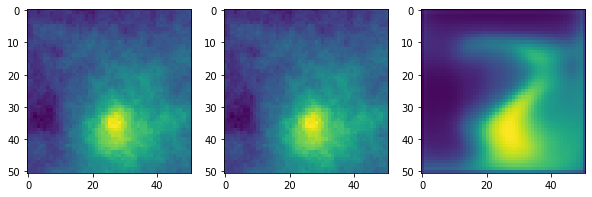

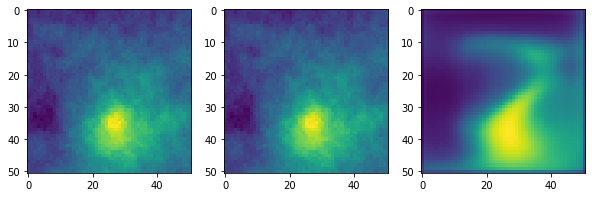

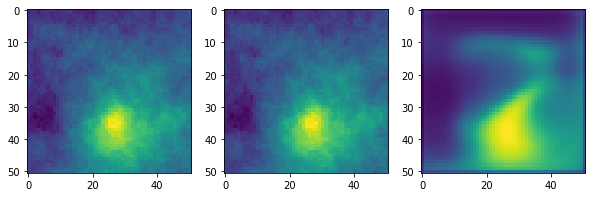

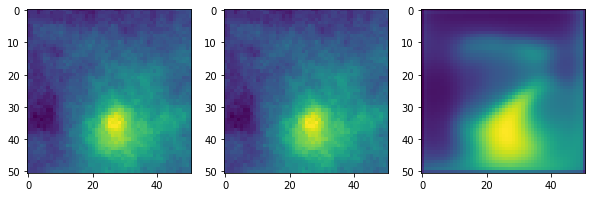

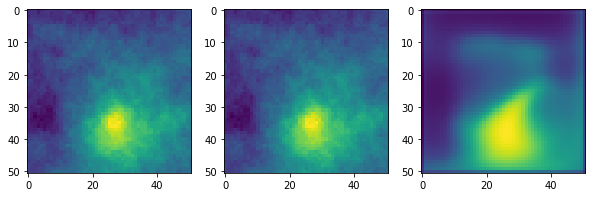

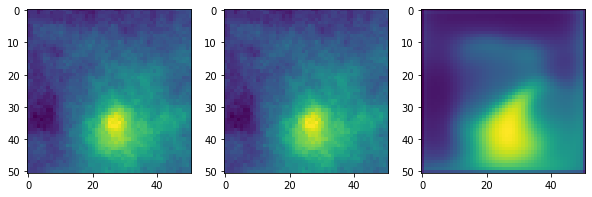

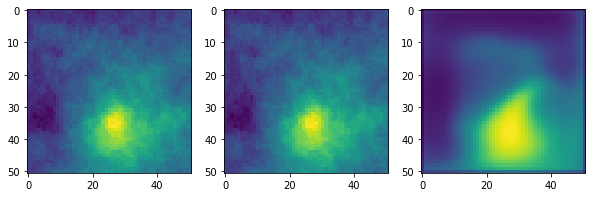

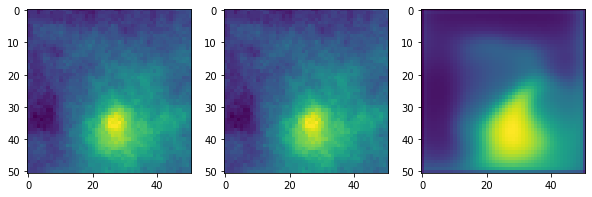

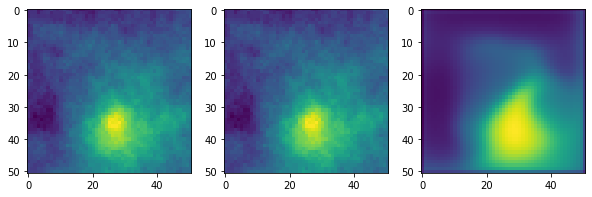

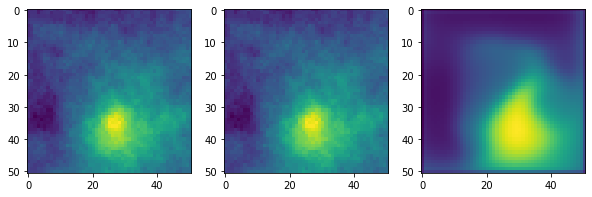

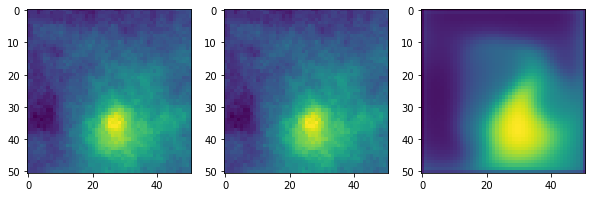

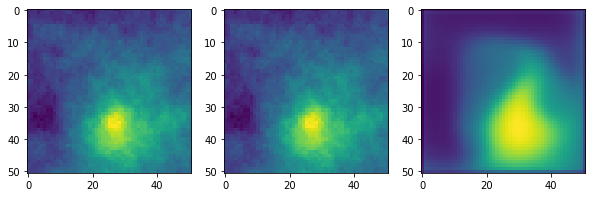

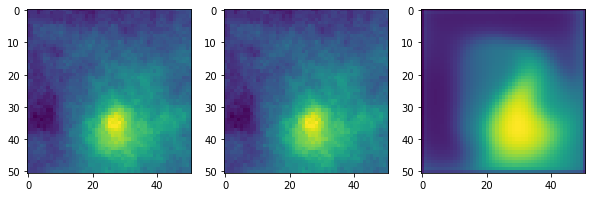

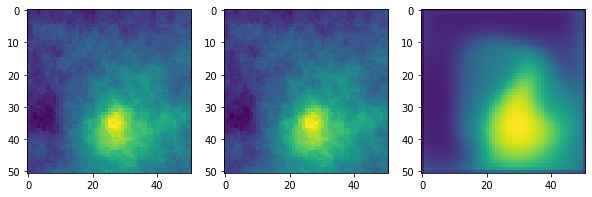

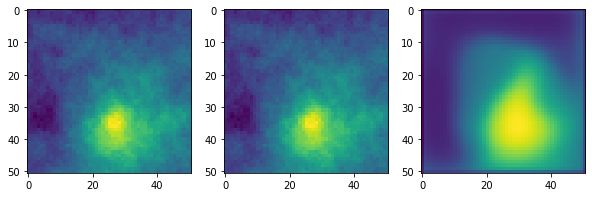

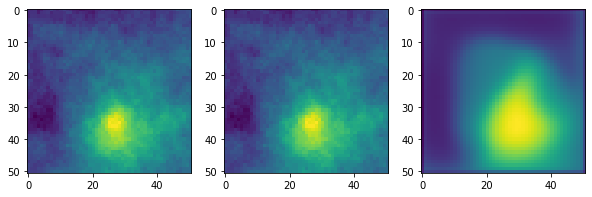

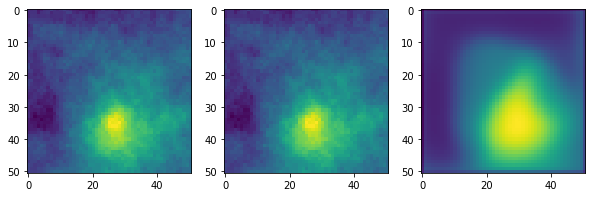

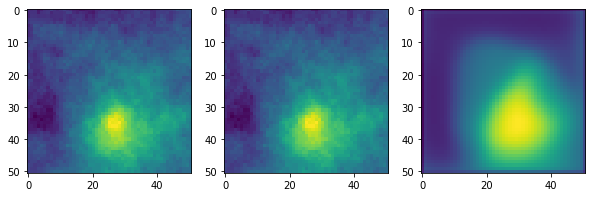

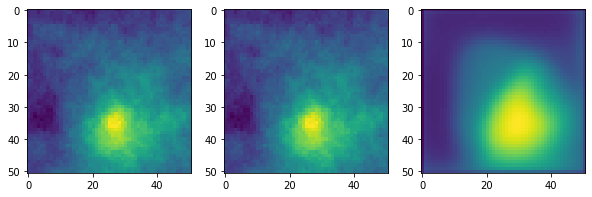

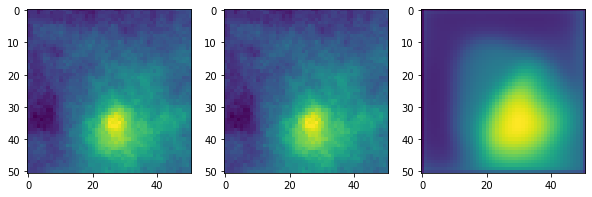

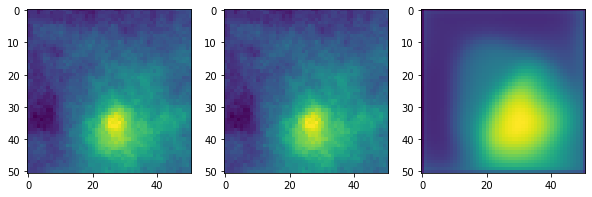

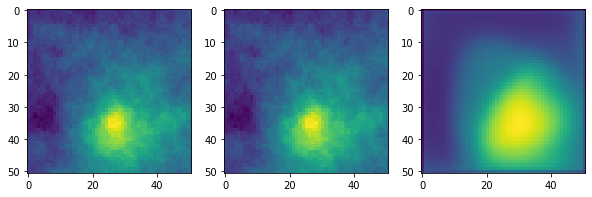

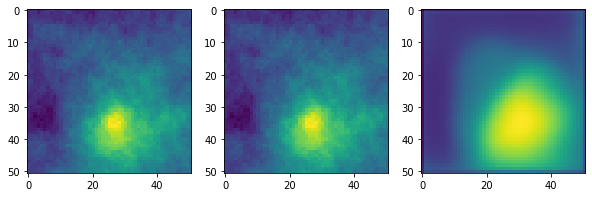

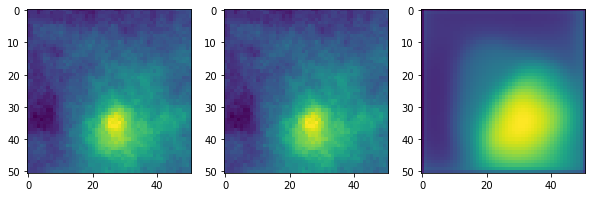

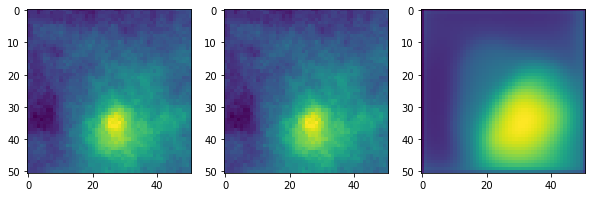

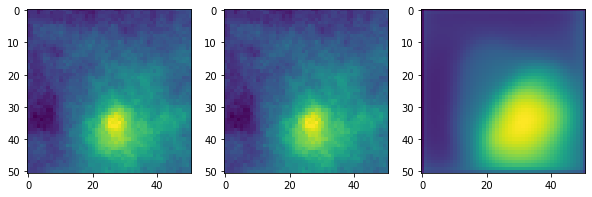

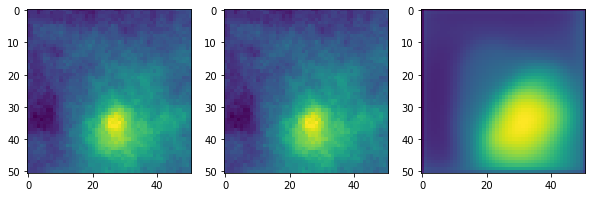

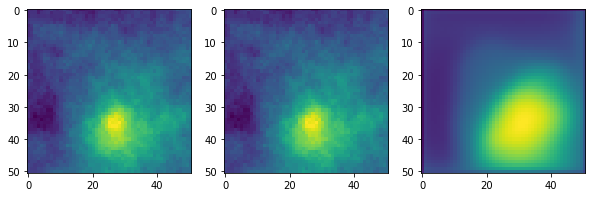

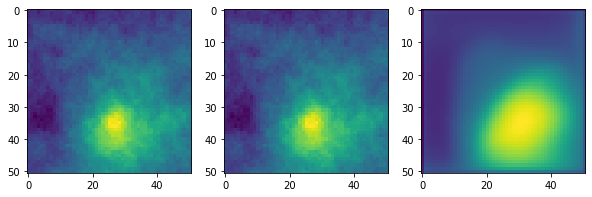

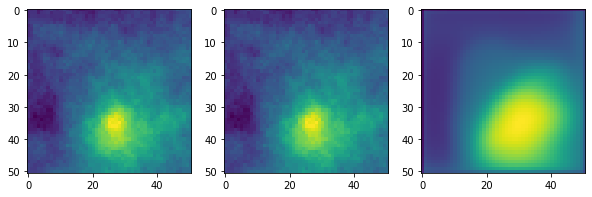

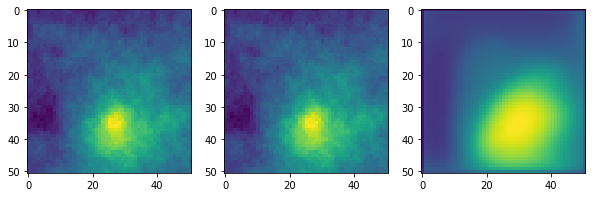

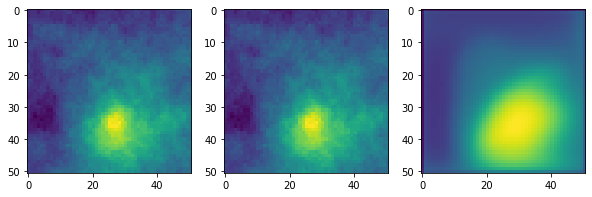

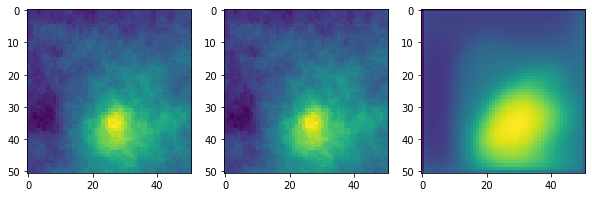

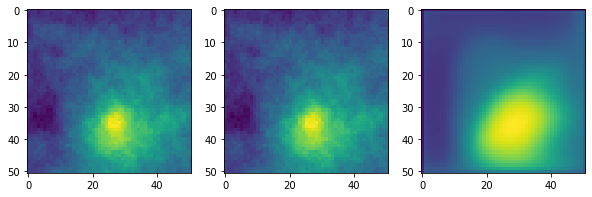

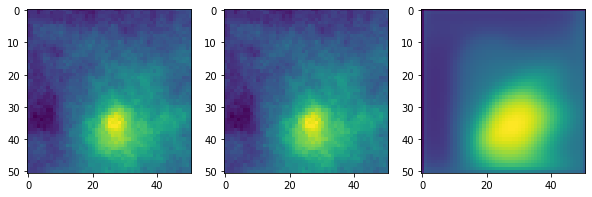

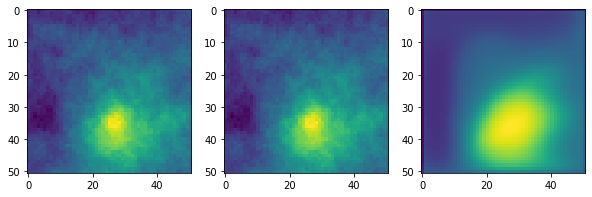

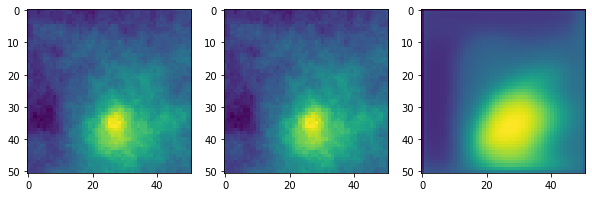

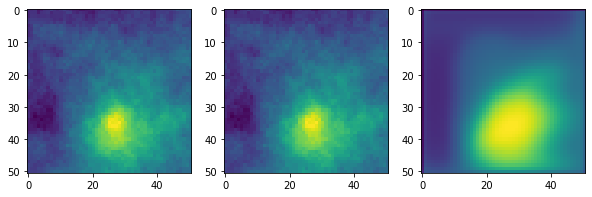

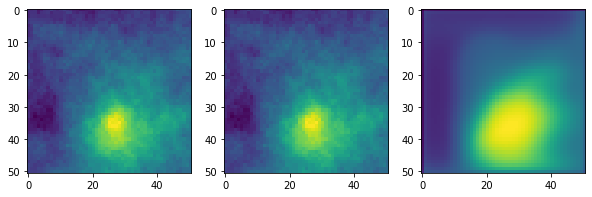

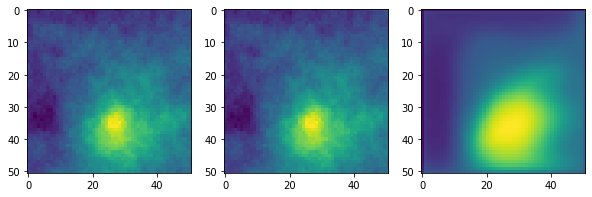

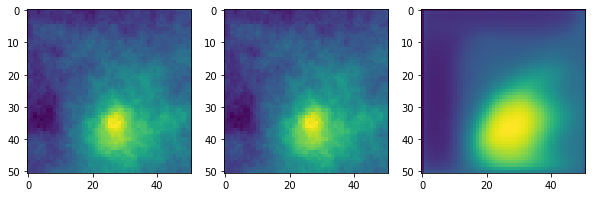

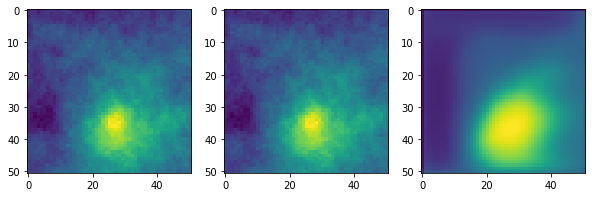

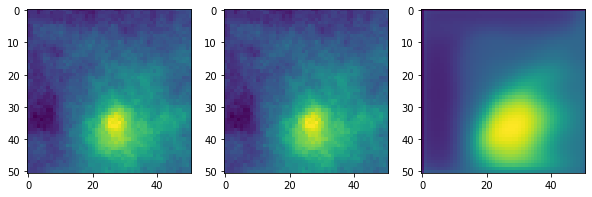

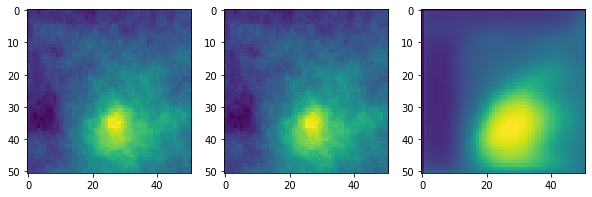

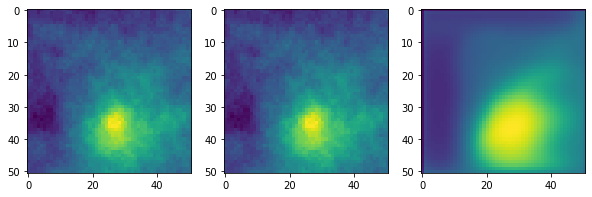

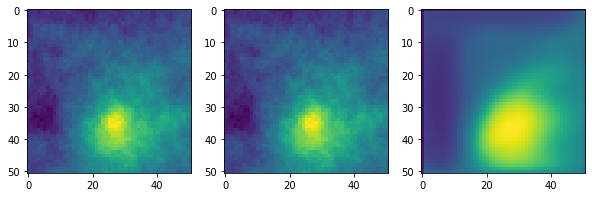

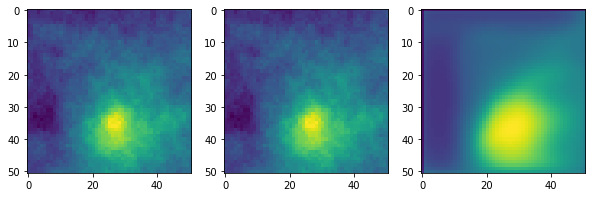

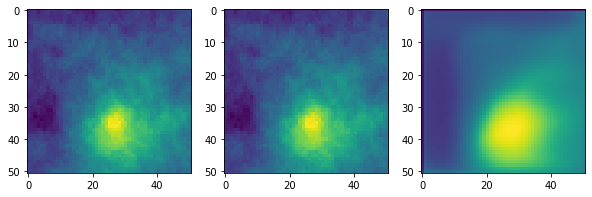

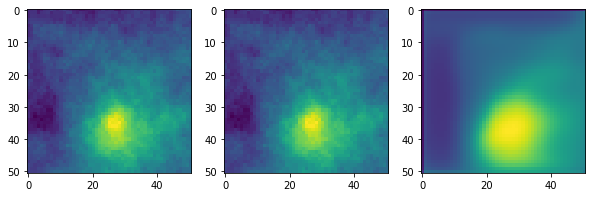

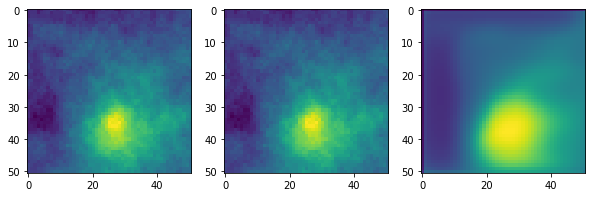

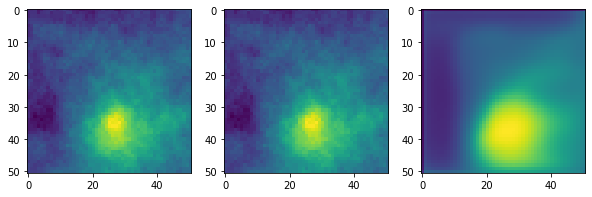

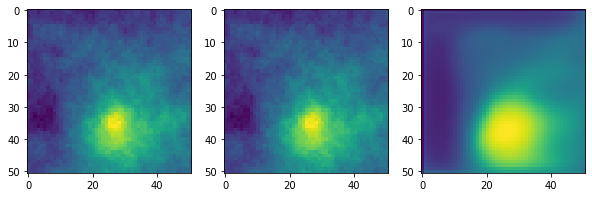

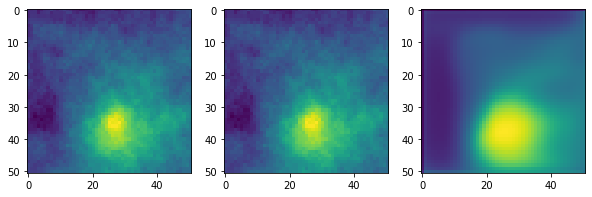

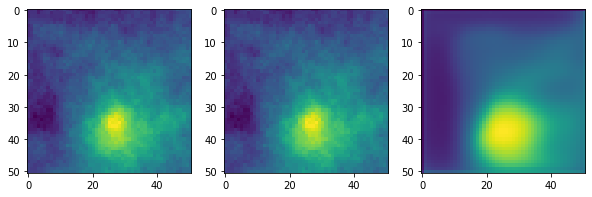

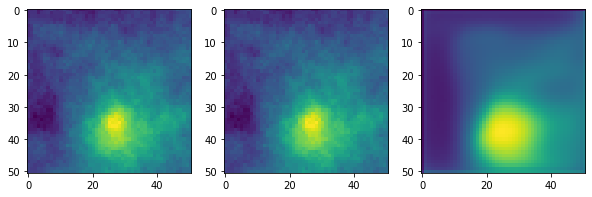

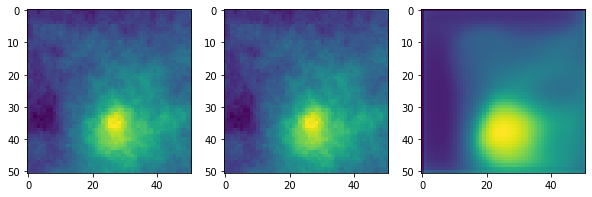

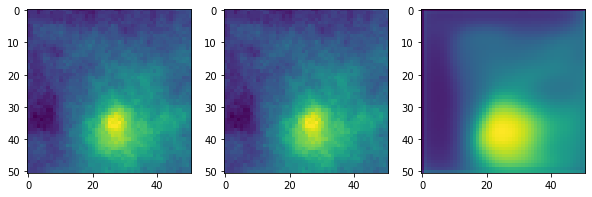

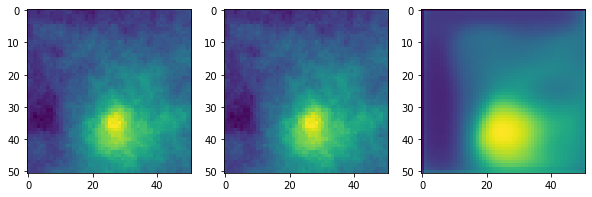

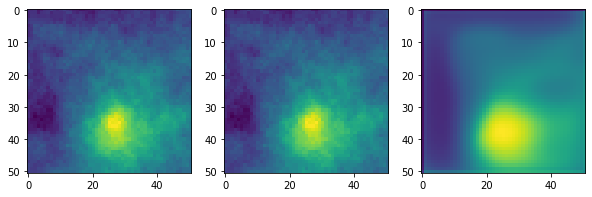

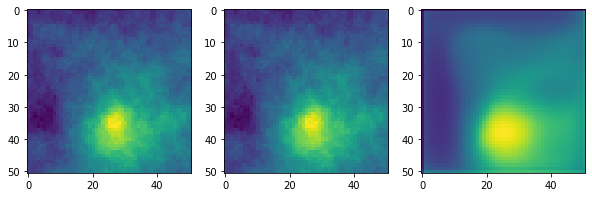

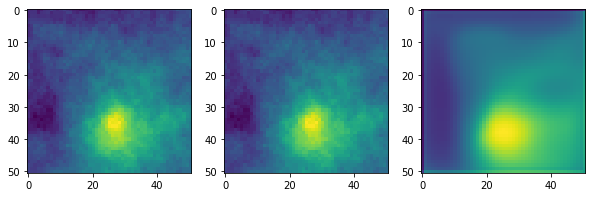

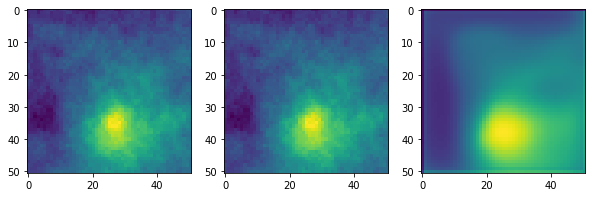

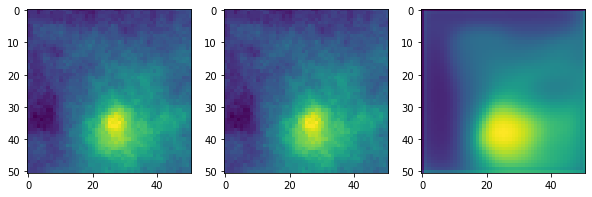

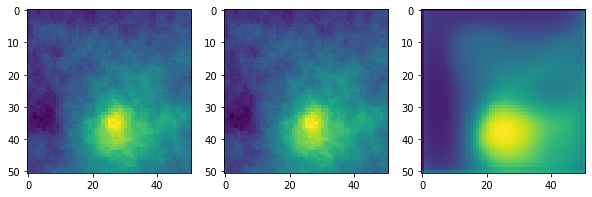

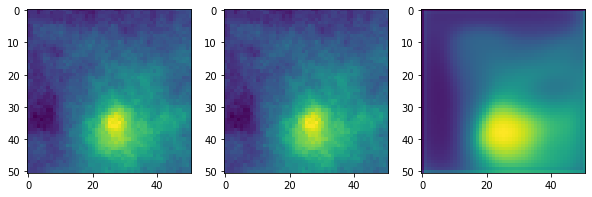

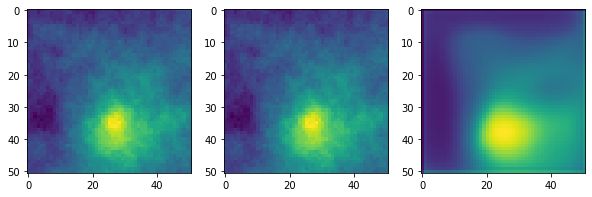

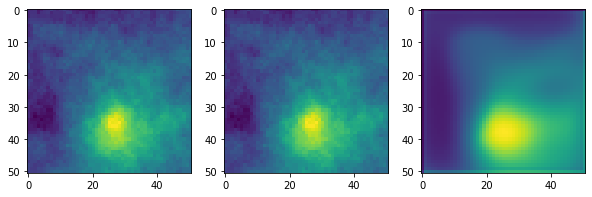

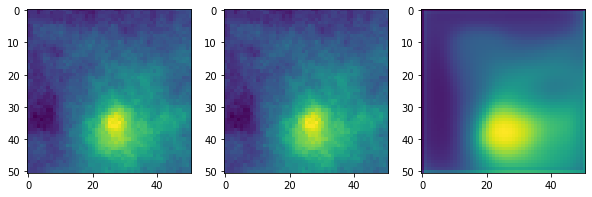

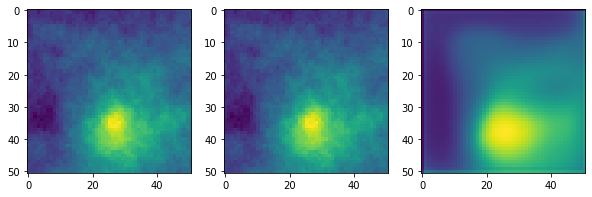

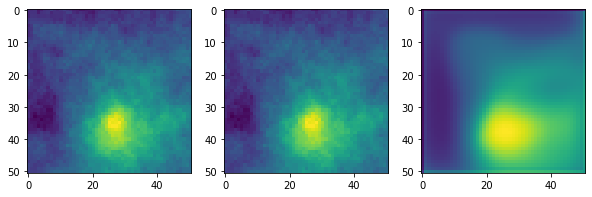

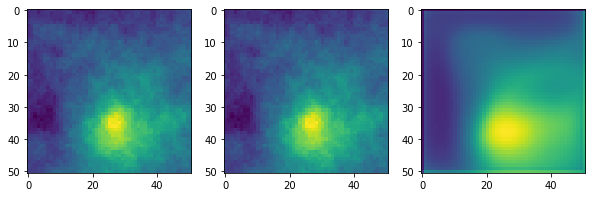

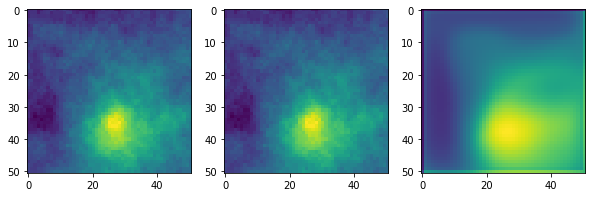

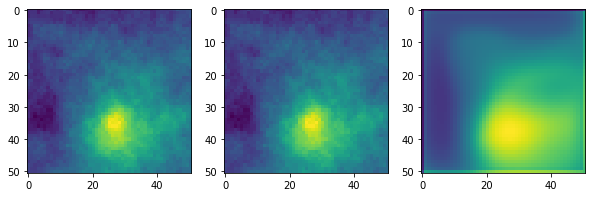

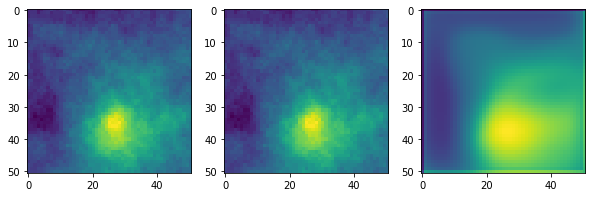

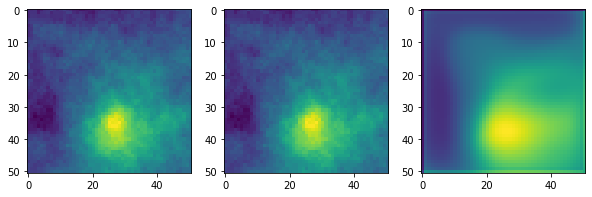

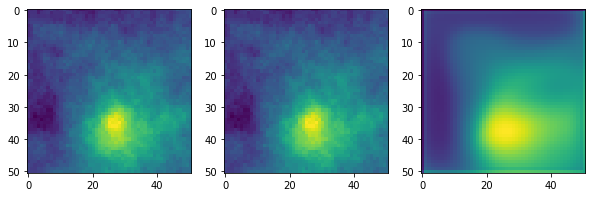

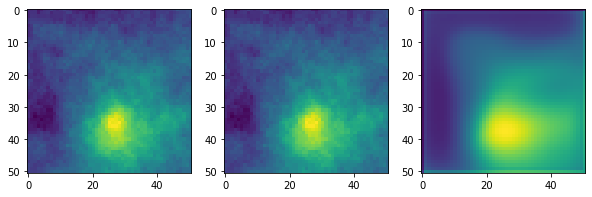

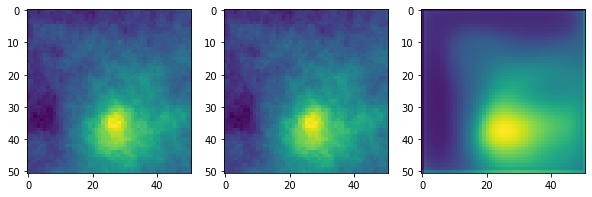

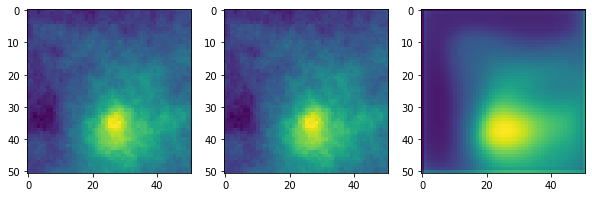

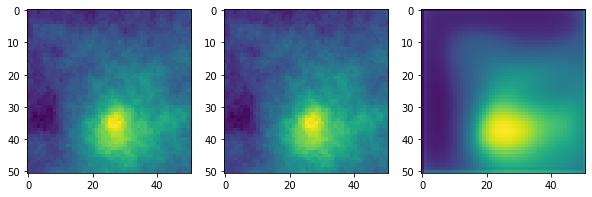

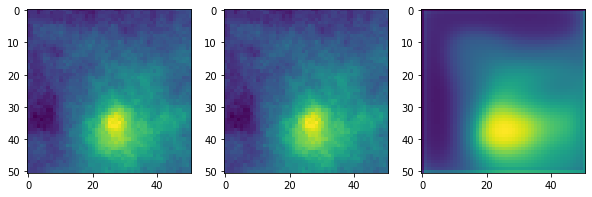

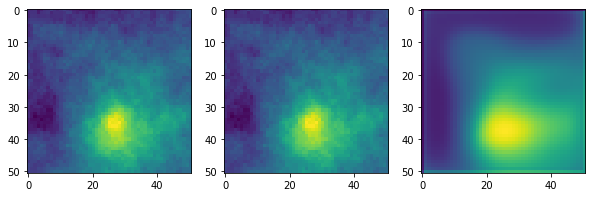

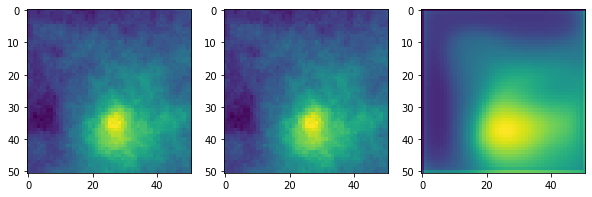

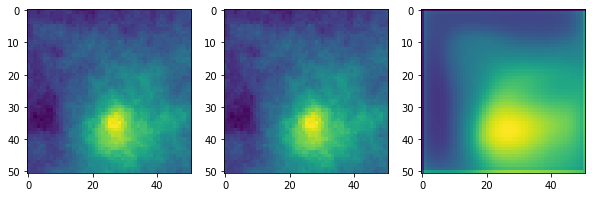

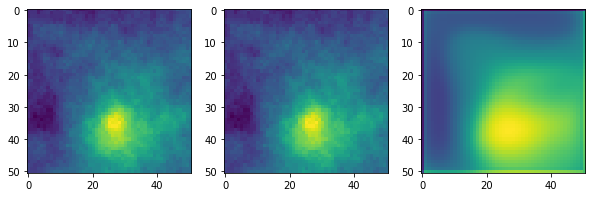

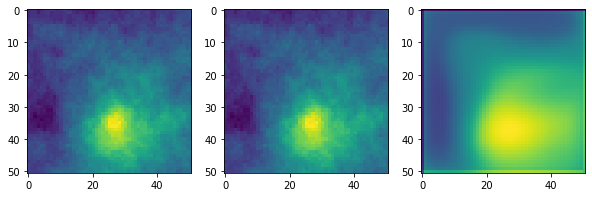

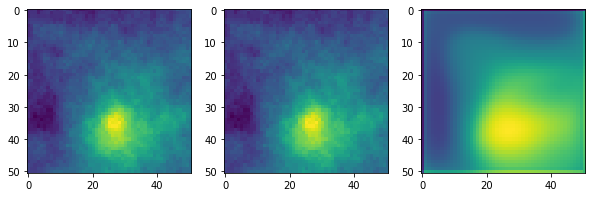

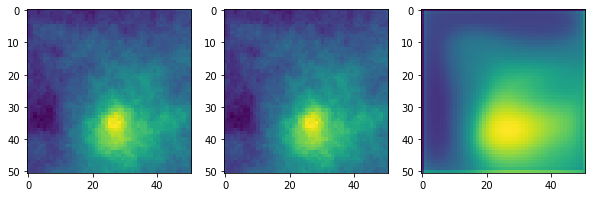

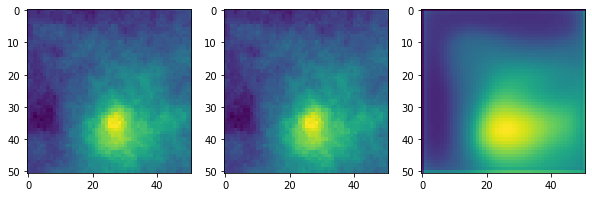

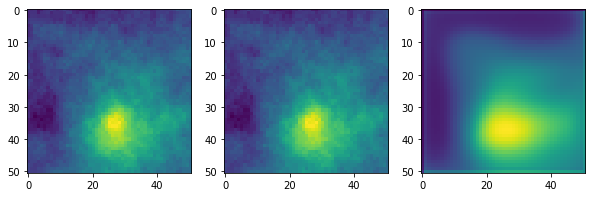

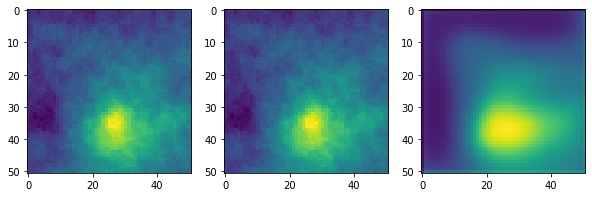

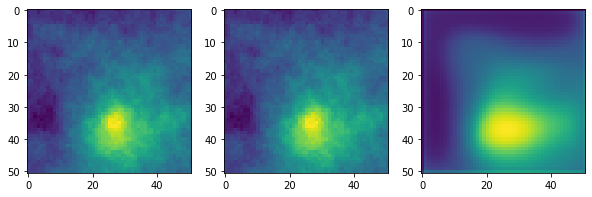

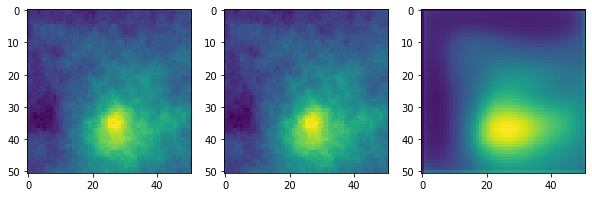

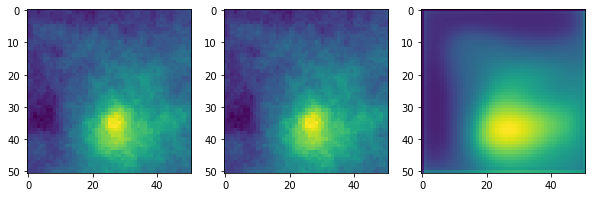

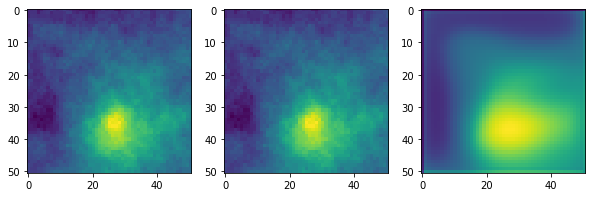

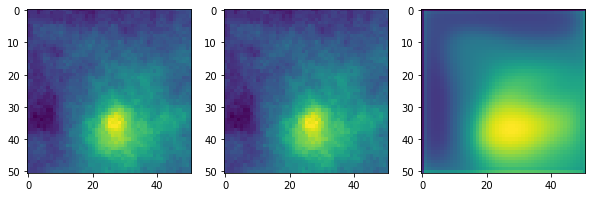

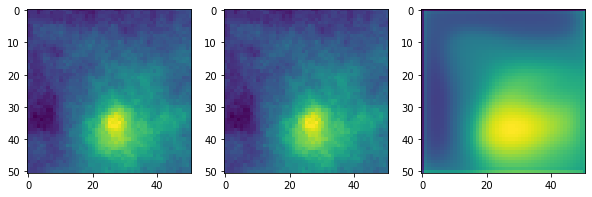

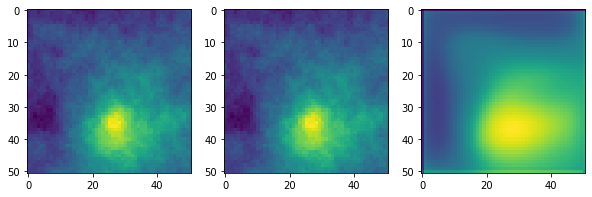

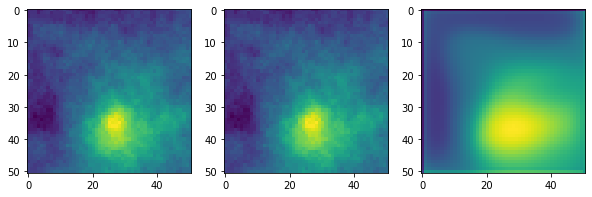

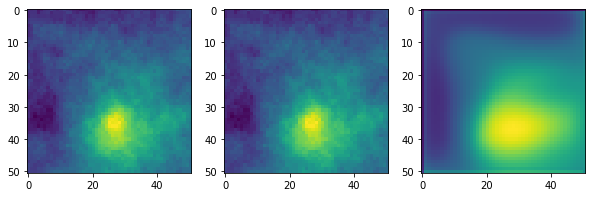

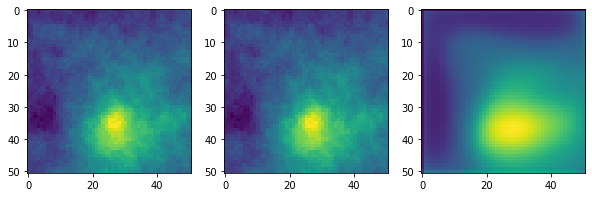

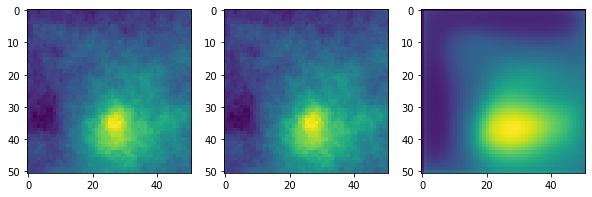

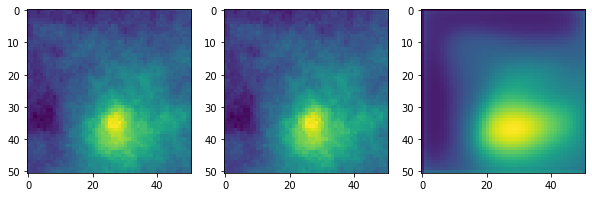

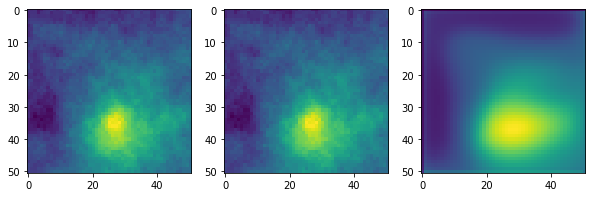

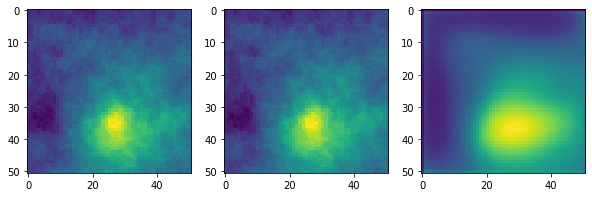

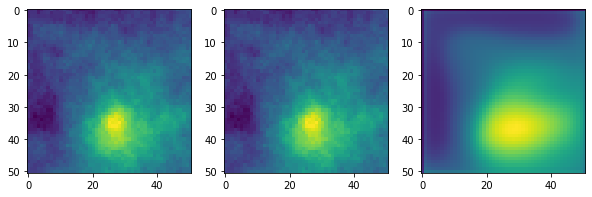

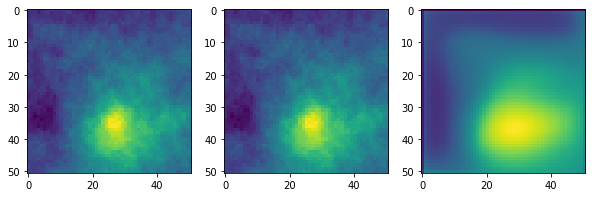

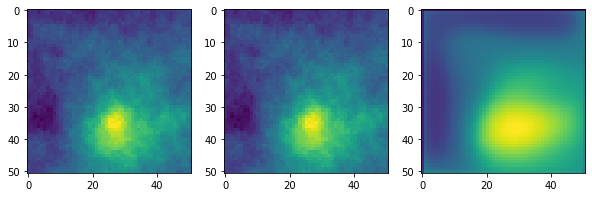

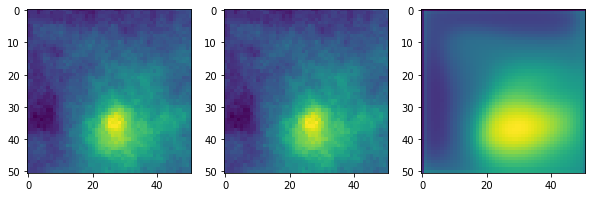

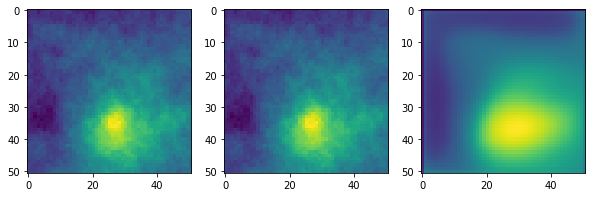

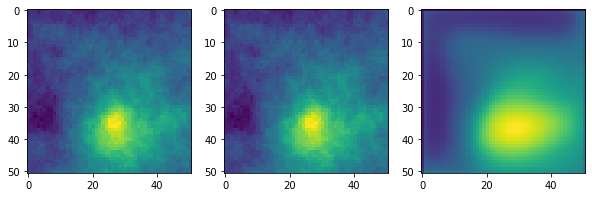

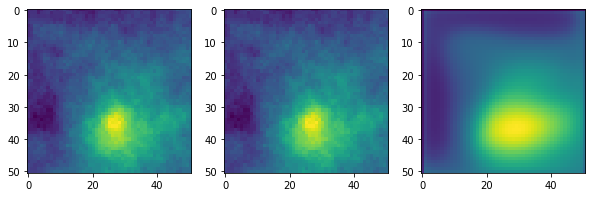

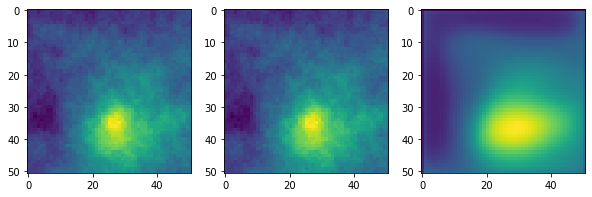

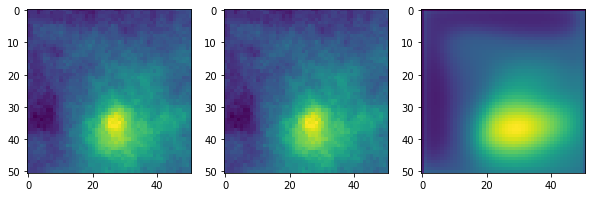

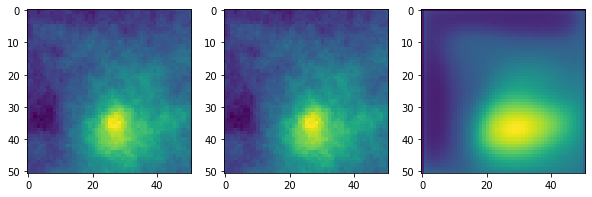

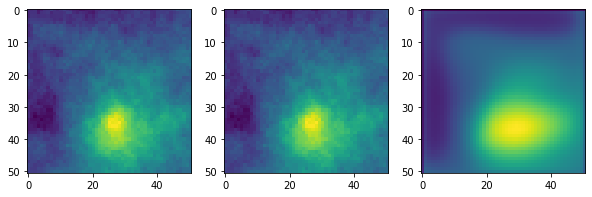

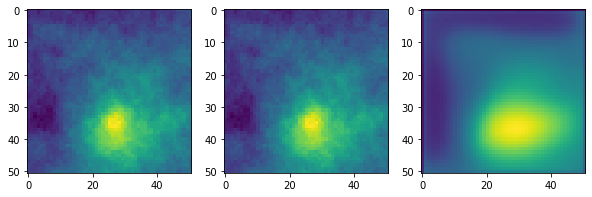

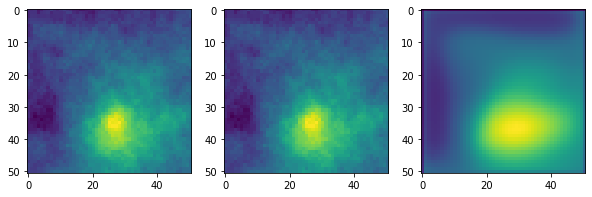

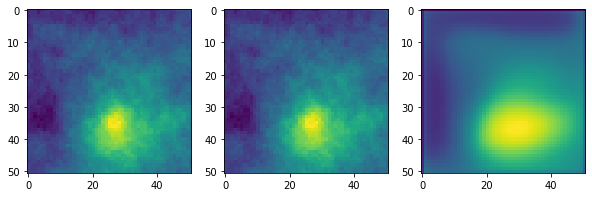

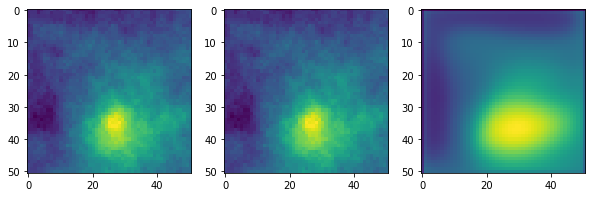

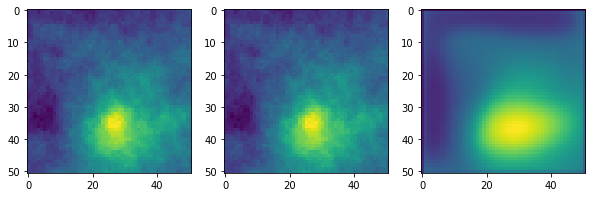

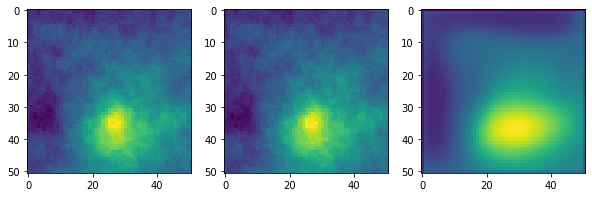

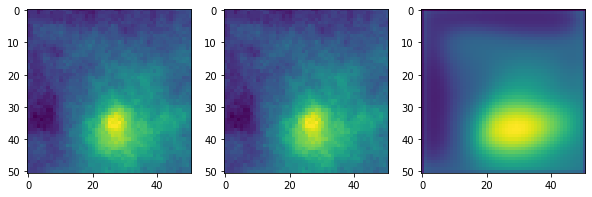

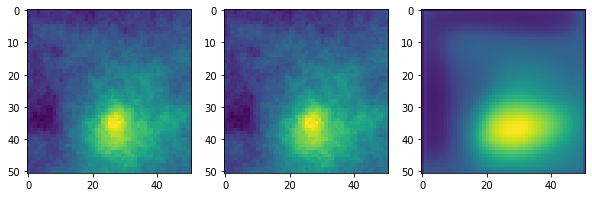

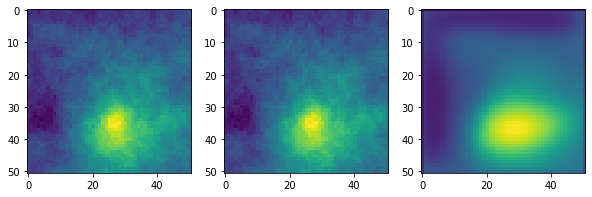

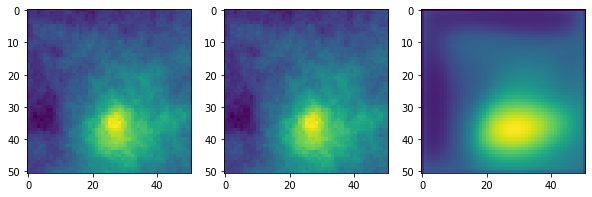

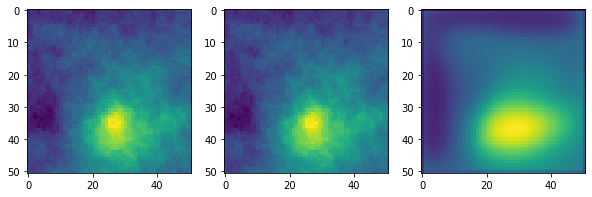

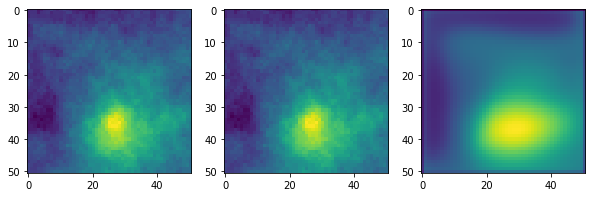

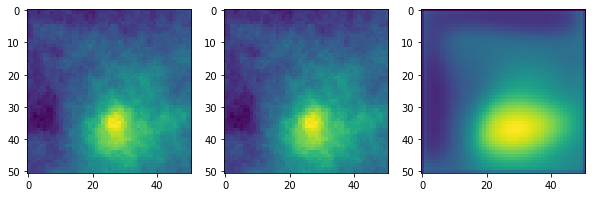

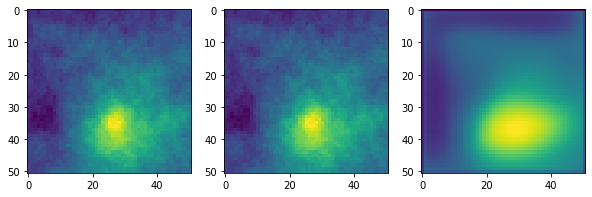

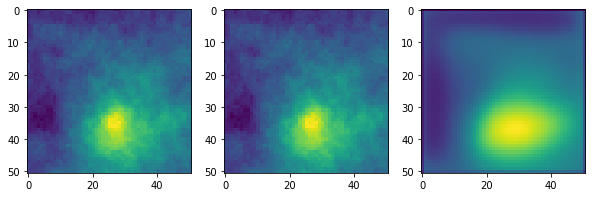

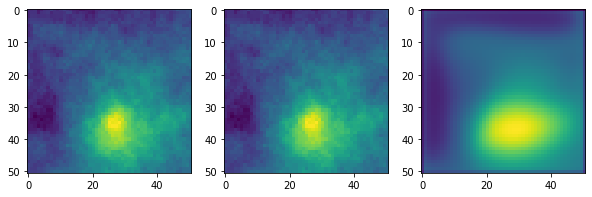

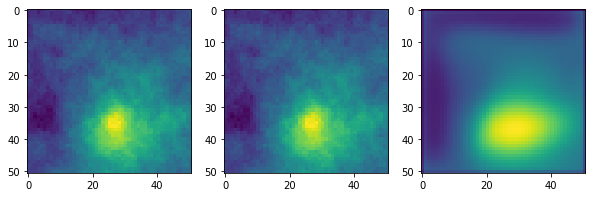

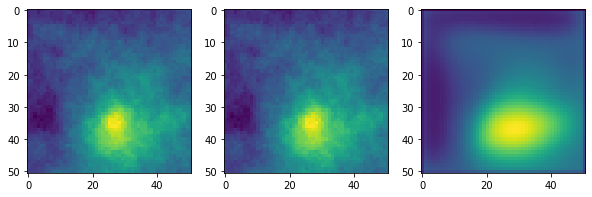

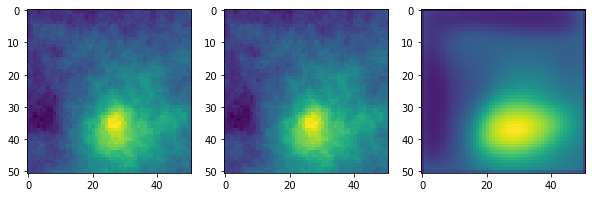

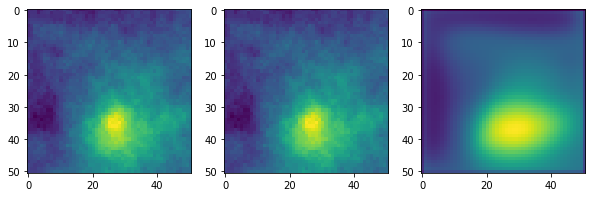

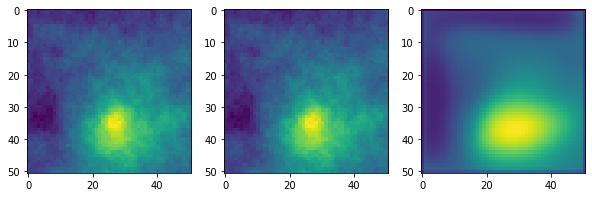

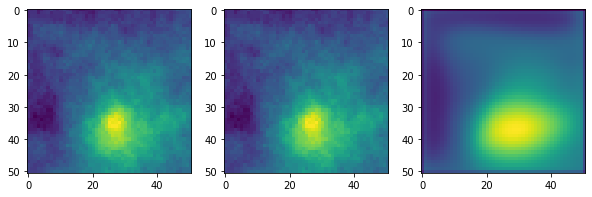

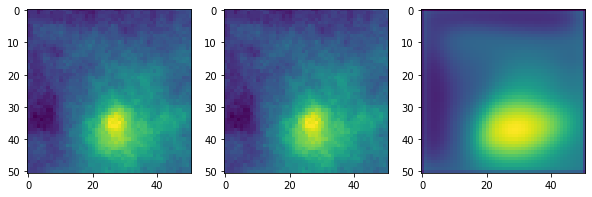

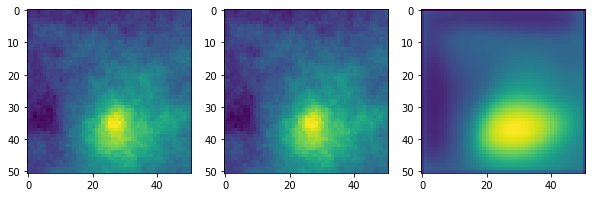

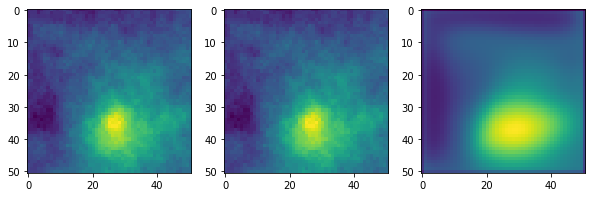

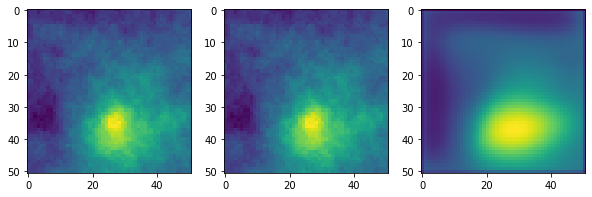

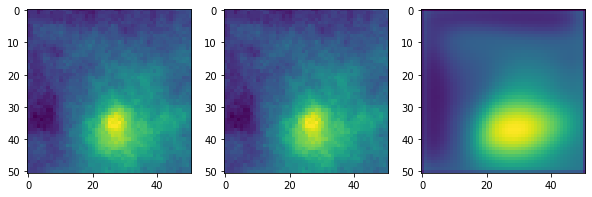

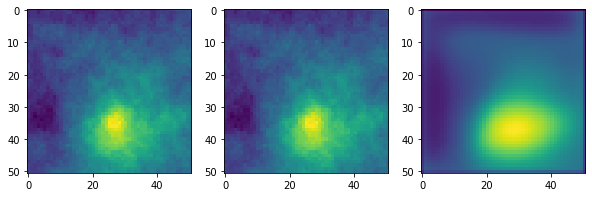

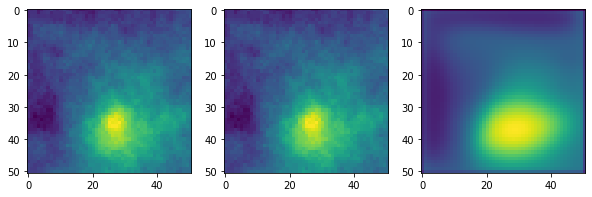

In [2]:
from IPython import display
import time
import torch
from torch import optim
a = train_set_slf[11][1].squeeze()
a = torch.log10(a+1e-10)
a = a.abs()/a.abs().max()

w = train_set_slf[11][0][0].squeeze()
w = torch.ones(51,51)
w = torch.bernoulli(w)

# z_init = torch.randn(1,2,51,51)


z_init = torch.randn(1,256)
sigma = 0.03
# generator = DipAE()
generator = DecoderDip()
# generator = AutoencoderSelu()

optimizer = optim.SGD(generator.parameters(), lr=0.00001)
loss_fn = torch.nn.L1Loss()
# generator.eval()

time_inter = 50
for i in range(10000):
#     z = z_init + torch.randn(z_init.shape)*sigma
    z = z_init.clone()
    t1 = time.time()
    out = generator(z)
    loss = loss_fn(w*out, w*a)
    loss.backward()
    optimizer.step()
    t1 = time.time() - t1
    if i%time_inter == 0:
        fig, ax = plt.subplots(1,3, figsize=(10,7))

        ax[2].imshow(-out.detach().squeeze().numpy())
        ax[1].imshow(-(w*a).detach().squeeze().numpy())
        ax[0].imshow(-a.squeeze().numpy())
        
        display.clear_output(wait=True)
    #     time.sleep(0.05)
        display.display(plt.gcf())
        print(i, loss.item(), t1)    
    

In [1]:
import scipy.io as sio


filepath = '/scratch/sagar/Projects/matlab/quantized_spectrum_cartography/qmc/data/slf128.mat'
f = sio.loadmat(filepath)


In [3]:
f['Sc'].shape

(128, 128)

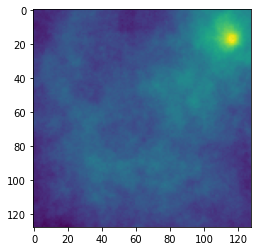

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.log(f['Sc']))

In [1]:
from networks.dip import DecoderDip
import torch
decoder = DecoderDip()

a = torch.randn(1,256)
b = decoder(a)

torch.Size([1, 256, 1, 1])
torch.Size([1, 256, 2, 2])
torch.Size([1, 128, 3, 3])
torch.Size([1, 128, 3, 3])
torch.Size([1, 128, 3, 3])
torch.Size([1, 128, 3, 3])
torch.Size([1, 128, 3, 3])
torch.Size([1, 128, 3, 3])
torch.Size([1, 128, 6, 6])
torch.Size([1, 64, 6, 6])
torch.Size([1, 64, 6, 6])
torch.Size([1, 64, 6, 6])
torch.Size([1, 64, 6, 6])
torch.Size([1, 64, 6, 6])
torch.Size([1, 64, 6, 6])
torch.Size([1, 64, 12, 12])
torch.Size([1, 32, 12, 12])
torch.Size([1, 32, 12, 12])
torch.Size([1, 32, 12, 12])
torch.Size([1, 32, 12, 12])
torch.Size([1, 32, 12, 12])
torch.Size([1, 32, 12, 12])
torch.Size([1, 32, 24, 24])
torch.Size([1, 16, 26, 26])
torch.Size([1, 16, 26, 26])
torch.Size([1, 16, 26, 26])
torch.Size([1, 16, 26, 26])
torch.Size([1, 16, 26, 26])
torch.Size([1, 16, 26, 26])
torch.Size([1, 16, 52, 52])
torch.Size([1, 2, 52, 52])
torch.Size([1, 2, 52, 52])
torch.Size([1, 2, 52, 52])
torch.Size([1, 2, 52, 52])
torch.Size([1, 2, 52, 52])
torch.Size([1, 2, 52, 52])
torch.Size([1, 1, 5

In [17]:
out.min()

tensor(0.4543, grad_fn=<MinBackward1>)

Text(0.5, 1.0, 'Reconstructed Map')

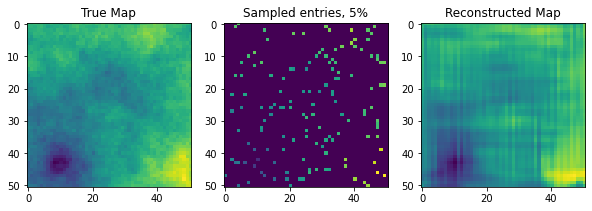

In [132]:

fig, ax = plt.subplots(1,3, figsize=(10,7))

ax[0].imshow(a.squeeze().numpy())
ax[0].set_title("True Map")
ax[1].imshow((w*a).detach().squeeze().numpy())
ax[1].set_title("Sampled entries, 5%")
ax[2].imshow(out.detach().squeeze().numpy())
ax[2].set_title("Reconstructed Map")


In [133]:
fig.savefig('data/dip_10_percent.pdf')

# QMC with DIP

In [ ]:
from slf_dataset import SLFDataset1bit, DEFAULT_ROOT
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy.io
import torch.nn as nn
import os
import sys
from networks.dip import DecoderDip

import scipy.io as sio
import torch
# observation 
from utils import *
from quantization_model_log import *
from tqdm import trange


SLF_ROOT = '/scratch/sagar/slf/train_set/set_harsh_torch_raw_unnormalized'

train_set_slf = SLFDataset1bit(root_dir=os.path.join(SLF_ROOT, 'slf_mat'), 
                    csv_file=os.path.join(SLF_ROOT, 'details.csv'), total_data=10000, sample_size=[0.1, 0.11])


data = sio.loadmat('../backup/data/onebitdata')

f = 0.1
std_probit = 0.008
# stds_probit = [0.00001, 0.0001, 0.001, 0.005, 0.008, 0.01, 0.02, 0.04]
stds_probit = [0.008]
nmse_list = []

loss_model = 'probit'  # one of 'sigmoid', 'probit', and 'determ'

S = torch.from_numpy(data['S']).type(torch.float32)
T = torch.from_numpy(data['T']).type(torch.float32)
C = torch.from_numpy(data['C']).type(torch.float32)
S_true = torch.from_numpy(data['S_true']).type(torch.float32)
C_true = torch.from_numpy(data['C_true']).type(torch.float32)
T_true = torch.from_numpy(data['T_true']).type(torch.float32)

Om = torch.from_numpy(data['Om']).type(torch.float32)
Om = torch.ones((64,1,51,51))*f
Om = torch.bernoulli(Om)

T = T.permute(2,0,1)
T_true = T_true.permute(2,0,1)
S = S.permute(2,0,1)
S_true = S_true.permute(2,0,1)
C = C.permute(1,0)
C_true = C_true.permute(1,0)

# W = Om.unsqueeze(dim=0)
# W = W.unsqueeze(dim=0)
# Wx = W.repeat(64,1,1,1)
Wx = Om

T_old = T.clone()
S_old = S.clone()


bin_boundaries = torch.tensor(QUANTIZATION_BOUNDARIES_7_ADJUSTED)


# parameters

z_dimension = 256
maxIter = 500
R,I,J = S.shape
K = 64
Z_init = torch.zeros((R, z_dimension), dtype=torch.float32)
Z = torch.zeros((R, z_dimension), dtype=torch.float32)
lambda_c = 0.01
lambda_s = 0.001

S_init = S.clone()
C_init = C.clone()
S_init = S_init.unsqueeze(dim=1)

S_init = torch.zeros(S_init.shape)
C_init = torch.zeros(C_init.shape)

T = T.unsqueeze(dim=1)
T_init = get_tensor(S_init, C_init)
# var_list = [SD_16_BINS_UNIFORM*8,SD_16_BINS_UNIFORM*4, SD_16_BINS_UNIFORM*2, SD_16_BINS_UNIFORM]
var_list = [SD_16_BINS_UNIFORM*2]
# var_list = [2,1.85, 1.65, 1.5, 1.4]
var_list = [1.5]
# init Z
# for r in range(R):
#     Z_init[r,:] = init_z(generator, S)

Z_init = torch.randn((R, 256))
generator = DecoderDip()
plot_iter = 10

nmses = np.zeros((len(var_list), maxIter))
costs = np.zeros((len(var_list), maxIter))
# costs = [[]]*len(var_list)

for var_id in range(len(var_list)):
    var = var_list[var_id]
    std_probit = var
#     T_true = torch.log(T_true)
    Y = quantize(T_true, std_probit, bin_boundaries)
    Y = Y.unsqueeze(dim=1)
    
    S = S_init.clone()
    C = C_init.clone()
    Z = Z_init.clone()

    Z = Z.detach().clone()
    C.requires_grad = True
    Z.requires_grad = True

    optimizerC = torch.optim.Adam([C], lr=0.005)
    optimizerZ = torch.optim.SGD(generator.parameters(), lr=0.001)
    generator.eval()
    
    with torch.no_grad():
        S = generator(Z)

    print("Initial nmse: {}".format(NMSE(get_tensor(generator(Z), C), T_true)))
    for i in trange(maxIter):
        # C optimization
        S = generator(Z)
        Sc = S.detach().clone()
        optimizerC.zero_grad()

        T_hat = get_tensor(Sc, C)
        T_hat = T_hat.unsqueeze(dim=1)
        T_hat = torch.log(T_hat+LOG_OFFSET_7_ADJUSTED)
        neg_log_likelihood = -torch.sum(Wx*torch.log(prob_probit(Y, T_hat, bin_boundaries, std_probit)))
        cost = neg_log_likelihood + lambda_c*torch.norm(C, 'fro') + lambda_s*torch.norm(S, 'fro')
        
        cost.backward()
        optimizerC.step()
        with torch.no_grad():
            C[C<0] = 0

#         true_loss = NMSE_LOG(get_tensor(S,C), T_true, LOG_OFFSET_7_ADJUSTED)
        
        true_loss = NMSE(get_tensor(S,C), T_true)
        nmses[var_id][i] = true_loss
        costs[var_id][i] = cost
        # S optimization
        optimizerZ.zero_grad()
        S = generator(Z)
        
        T_hat = get_tensor(S, C)
        T_hat = T_hat.unsqueeze(dim=1)
        T_hat = torch.log(T_hat+LOG_OFFSET_7_ADJUSTED)
        neg_log_likelihood = -torch.sum(Wx*torch.log(prob_probit(Y, T_hat, bin_boundaries, std_probit)))
        cost = neg_log_likelihood + lambda_c*torch.norm(C, 'fro') + lambda_s*torch.norm(S, 'fro')
        
        cost.backward()
        optimizerZ.step()

        true_loss = NMSE(get_tensor(S,C), T_true)
        nmses[var_id][i] = true_loss
        costs[var_id][i] = cost
        
        if i%plot_iter == 0:
            fig, ax = plt.subplots(2,3, figsize=(20,15))

            ax[0,0].imshow(torch.log(S_true[0,...]).squeeze().detach().numpy())
            ax[0,0].set_title('True SLF, 5% sampling')
            ax[1,0].imshow(torch.log(S[0,...]).squeeze().detach().numpy())
            ax[1,0].set_title('Final Reconstruction')

            ax[0,1].plot(C_true[0,:].detach().numpy())
            ax[0,1].set_title('True PSD')
            ax[1,1].plot(C[0,:].detach().numpy())
            ax[1,1].set_title('Final Reconstruction')


            ax[0,1].plot(C_true[1,:].detach().numpy())
            ax[0,1].set_title('True PSD')
            ax[1,1].plot(C[1,:].detach().numpy())
            ax[1,1].set_title('Final Reconstruction')

            k = 17
            T_hat = get_tensor(S, C)

            ax[0,2].imshow(torch.log(T_true[k,...]).squeeze().detach().numpy())
            ax[0,2].set_title('True Map')
            ax[1,2].imshow(torch.log(T_hat[k,...]).squeeze().detach().numpy())
            ax[1,2].set_title('Final Reconstruction')
            
            display.clear_output(wait=True)
            display.display(plt.gcf())
    print('ended {}'.format(std_probit))
    nmse_list.append(true_loss)

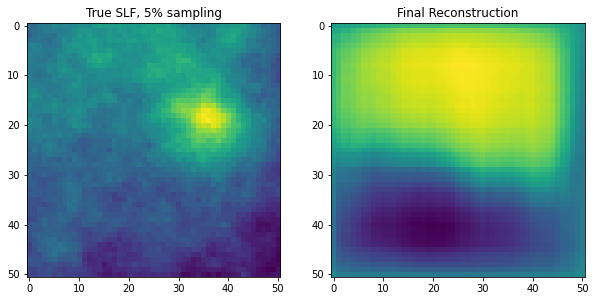

KeyboardInterrupt: 

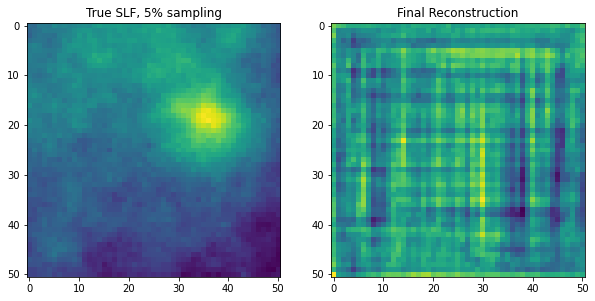

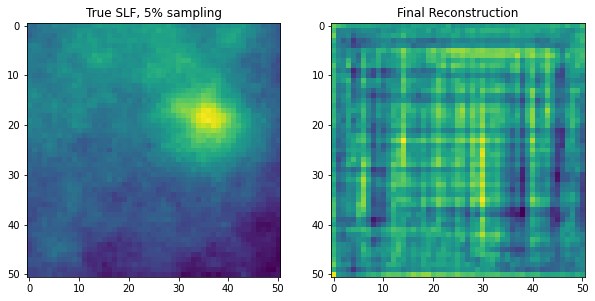

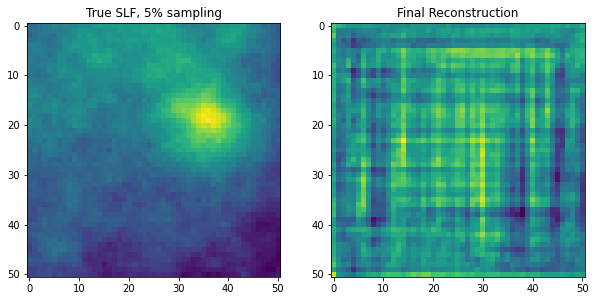

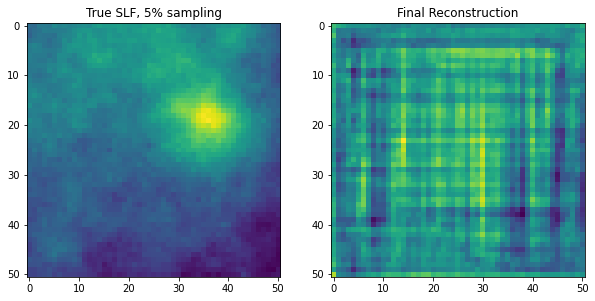

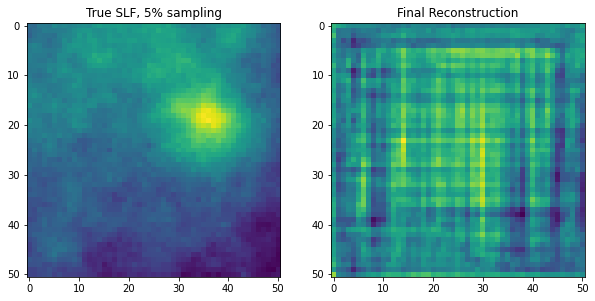

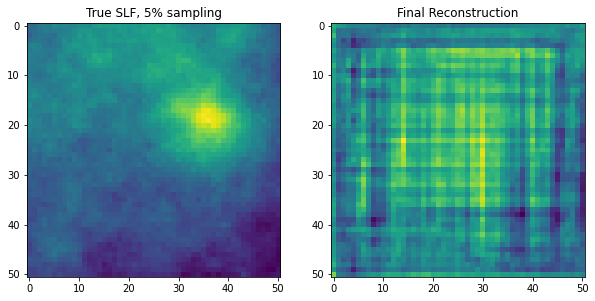

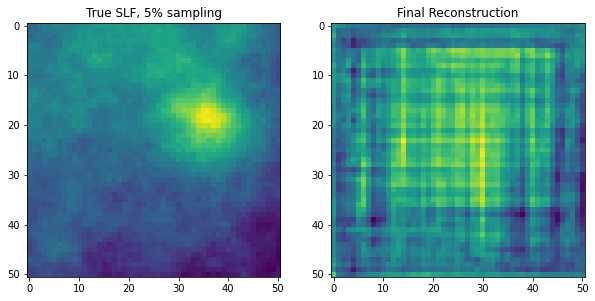

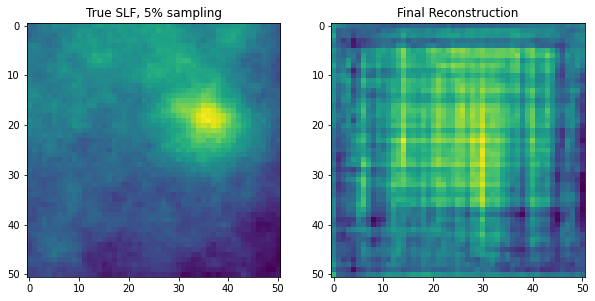

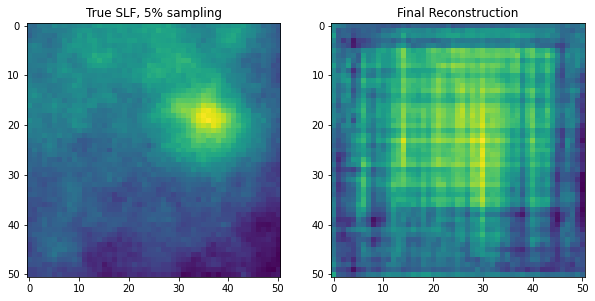

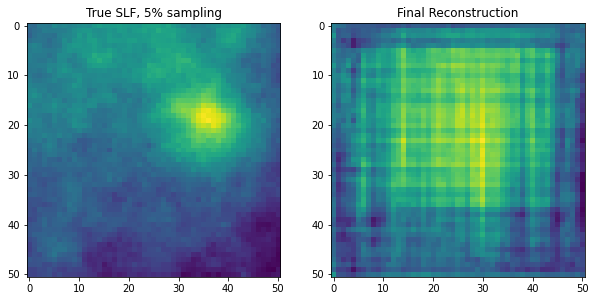

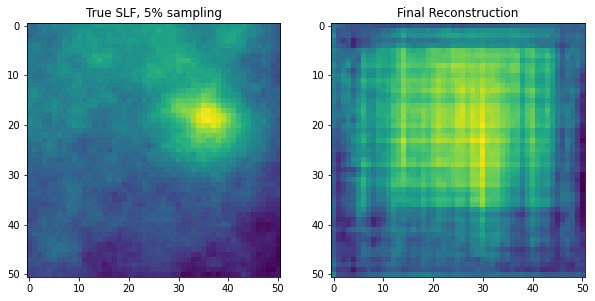

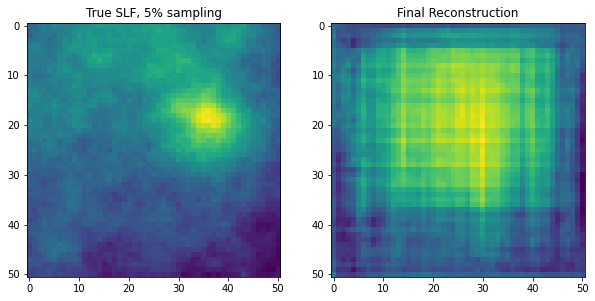

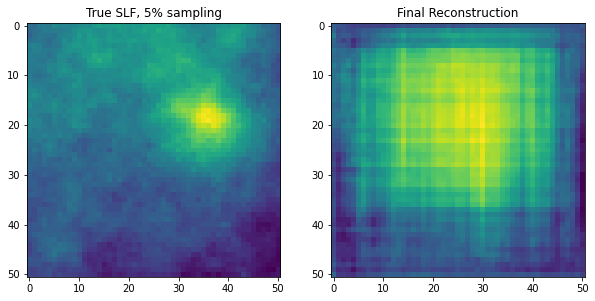

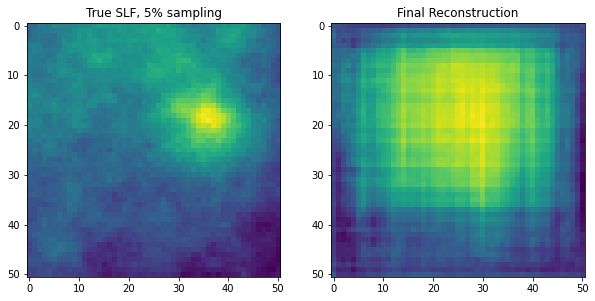

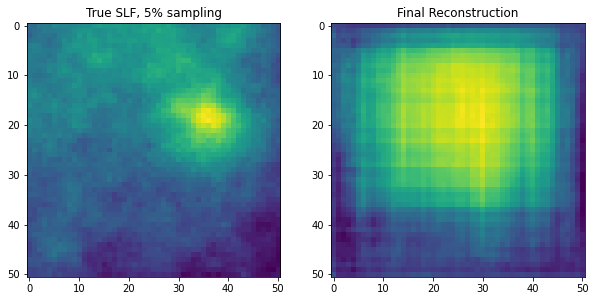

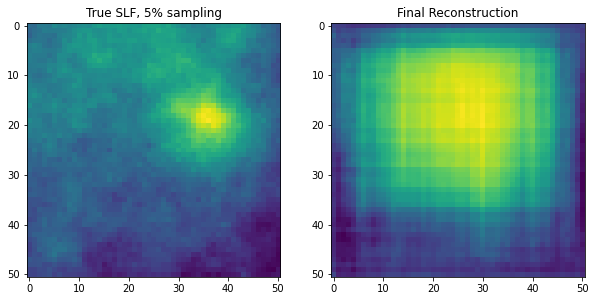

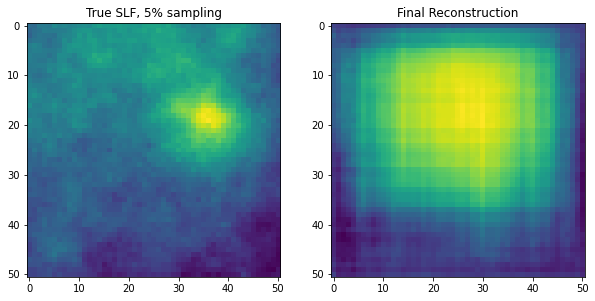

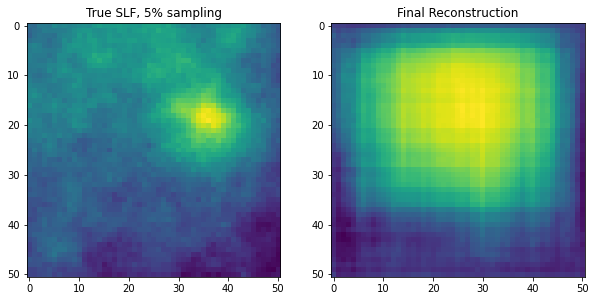

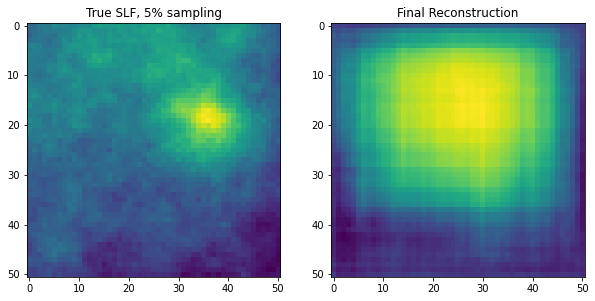

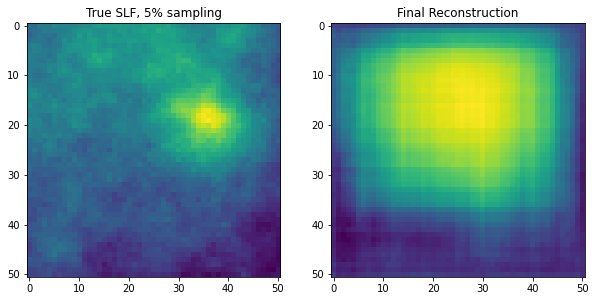

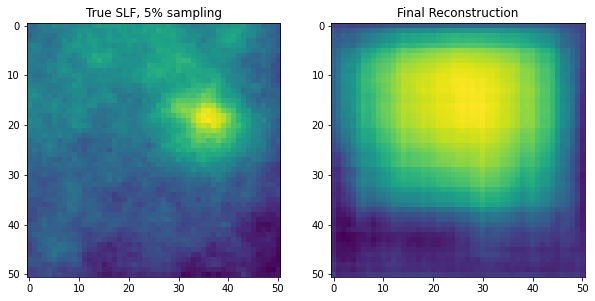

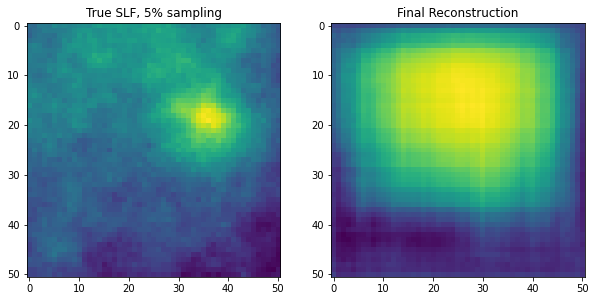

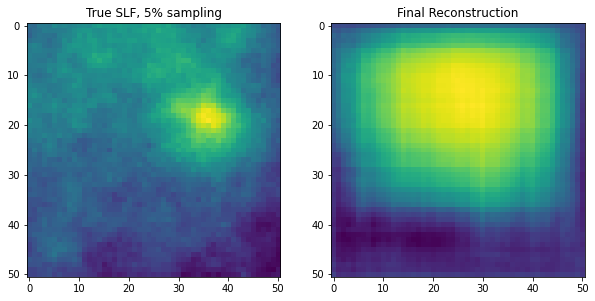

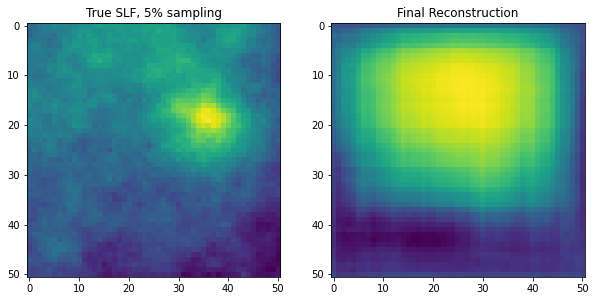

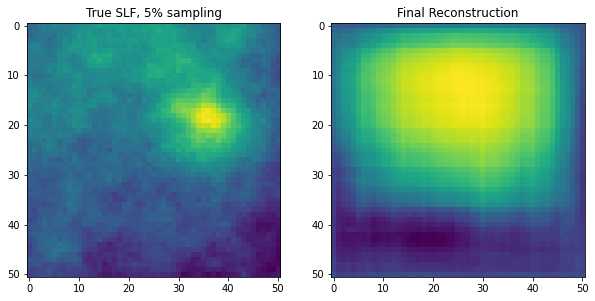

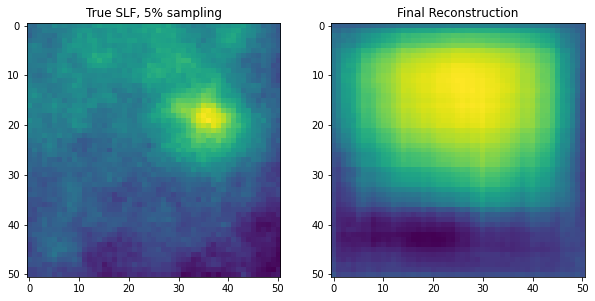

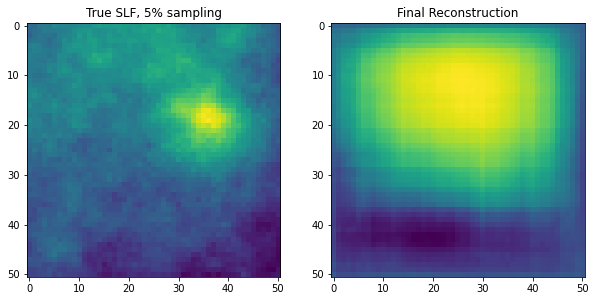

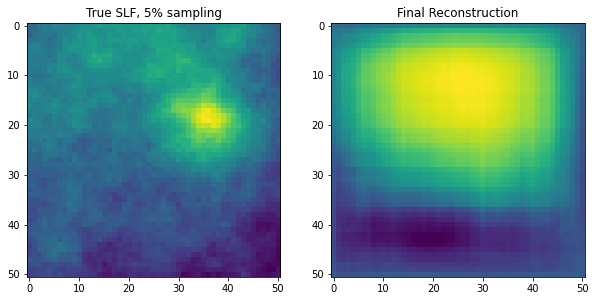

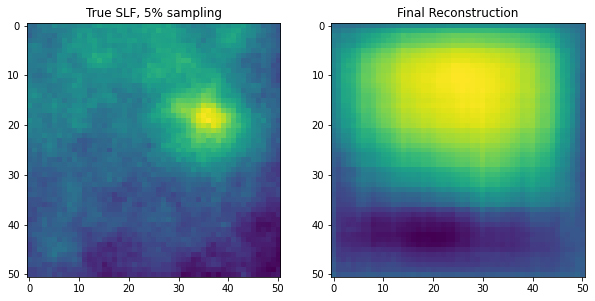

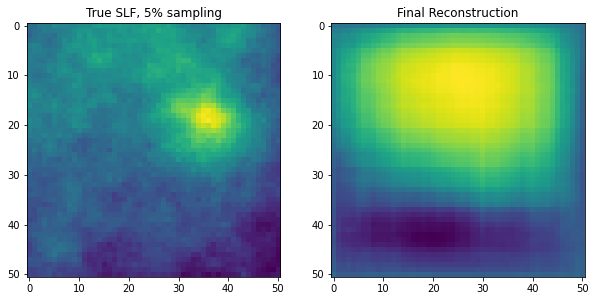

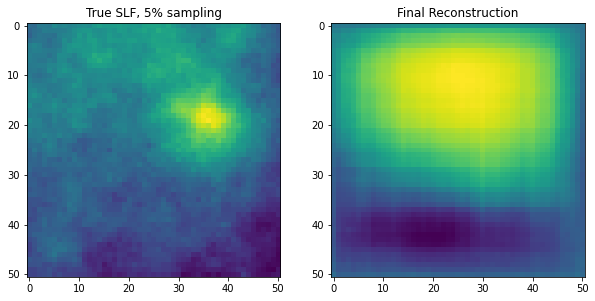

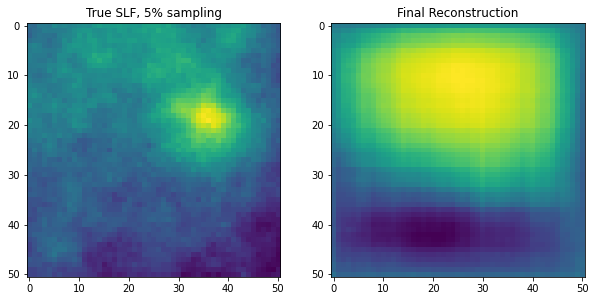

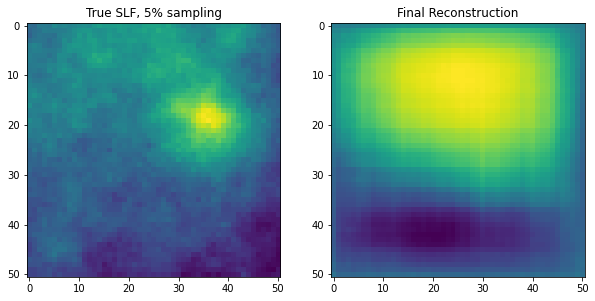

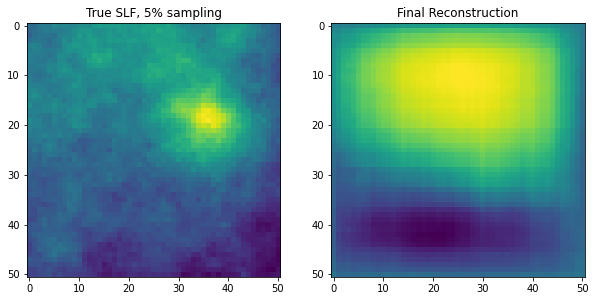

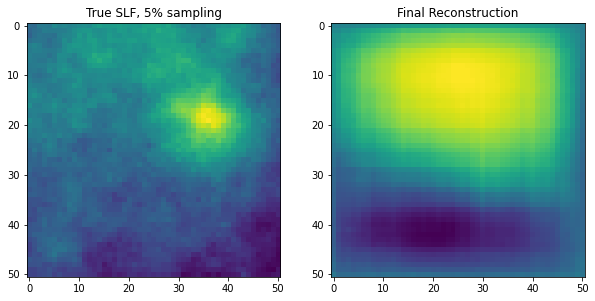

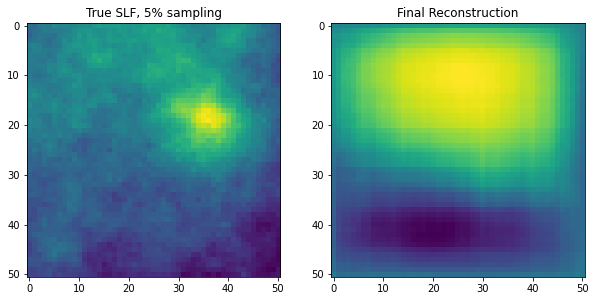

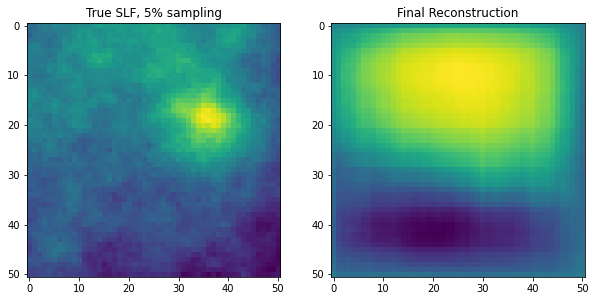

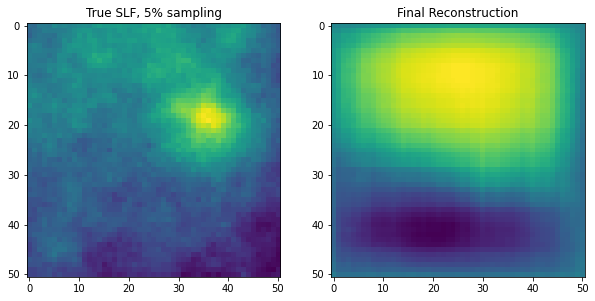

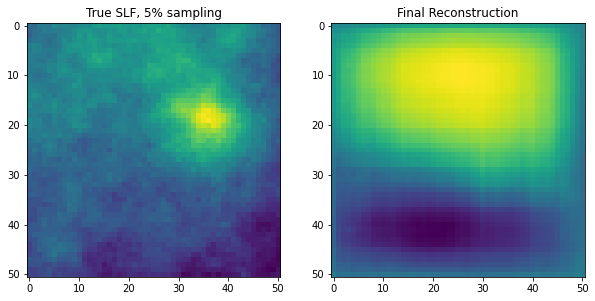

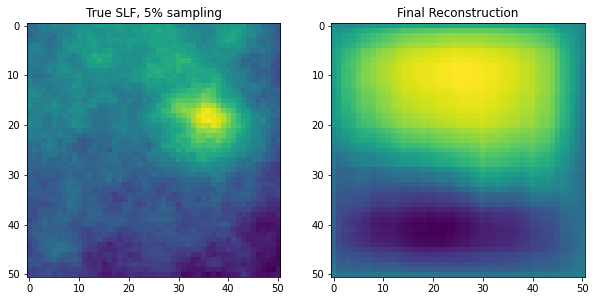

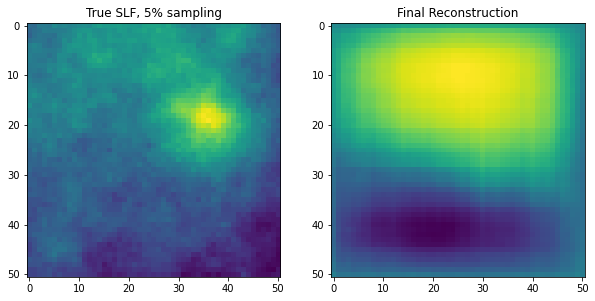

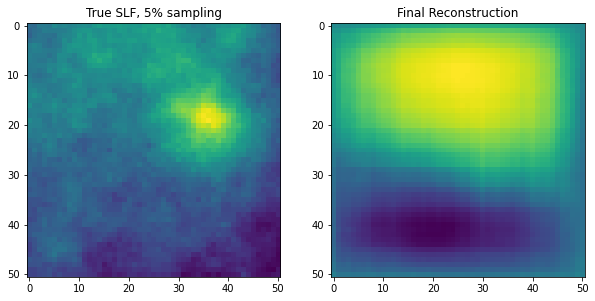

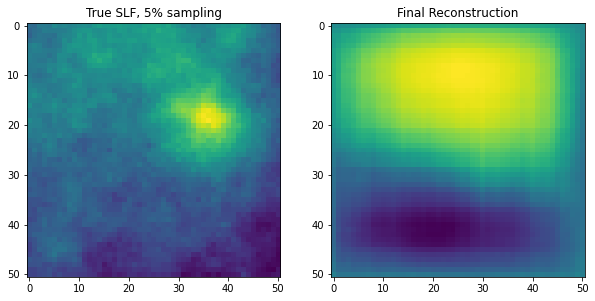

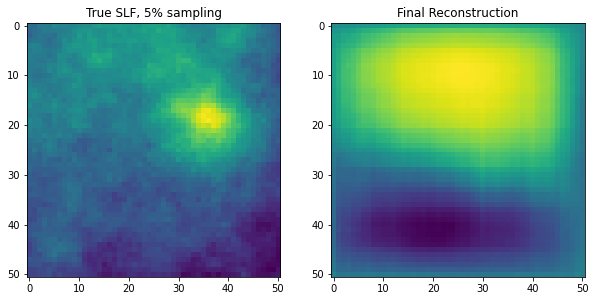

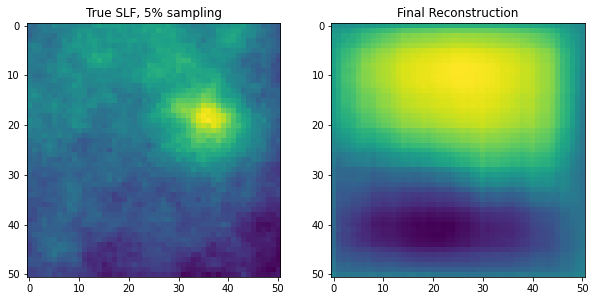

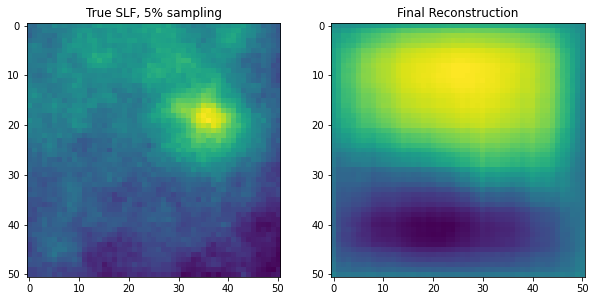

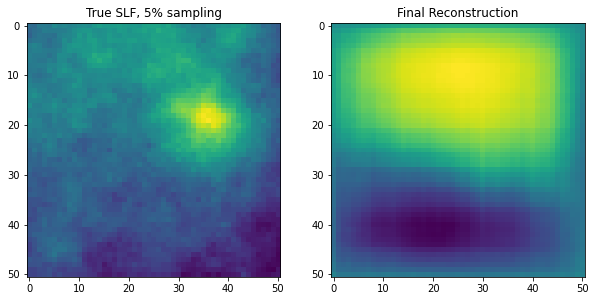

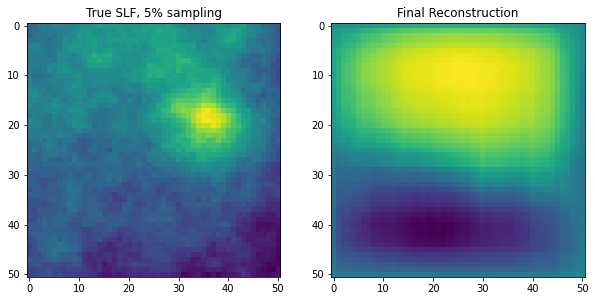

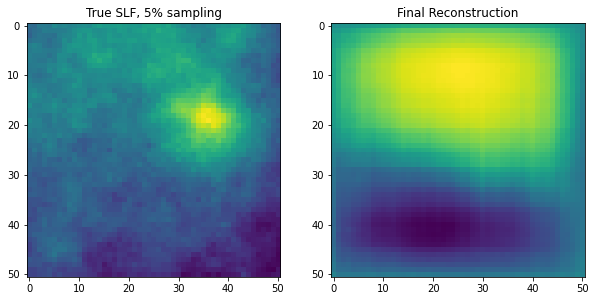

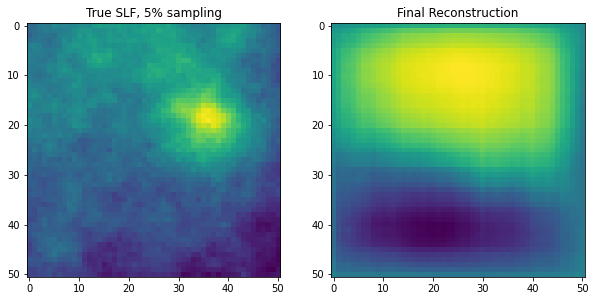

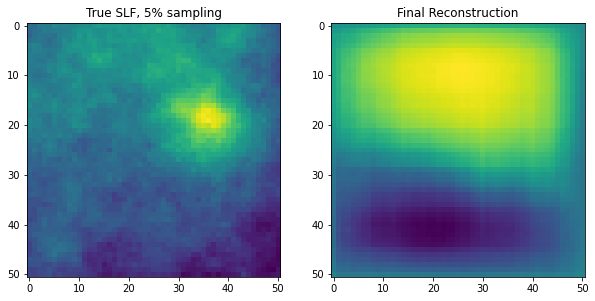

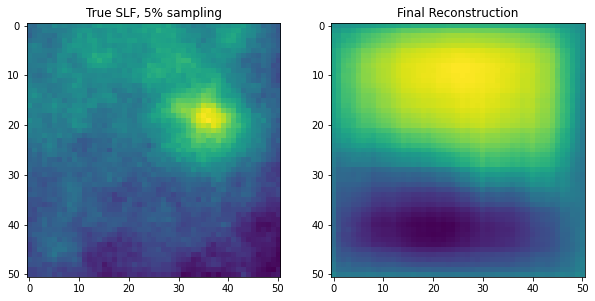

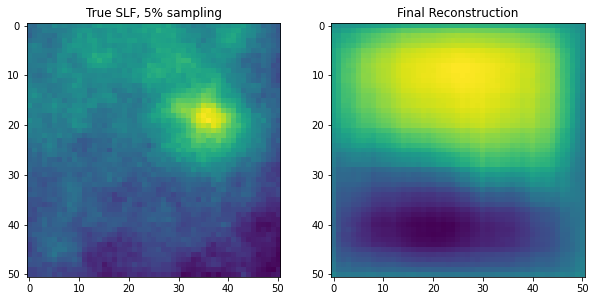

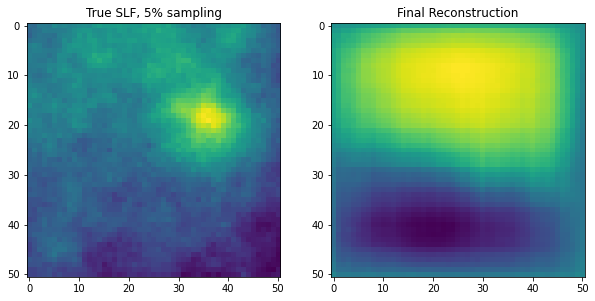

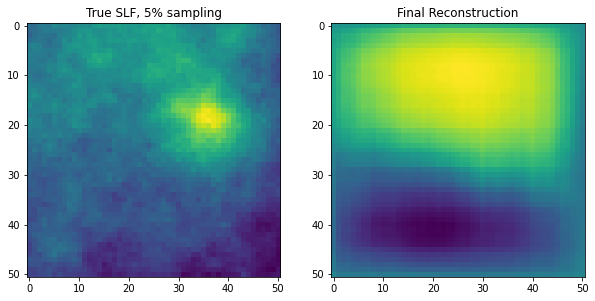

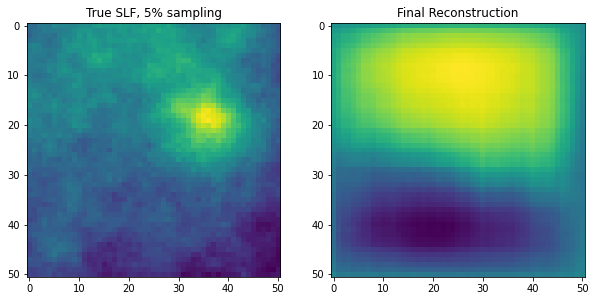

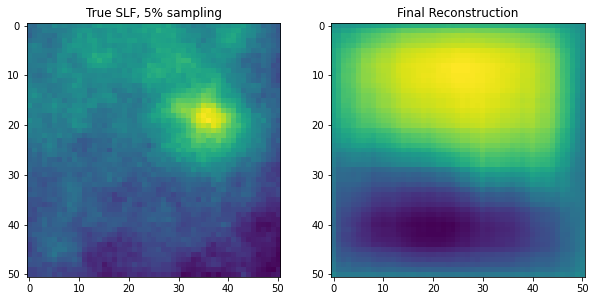

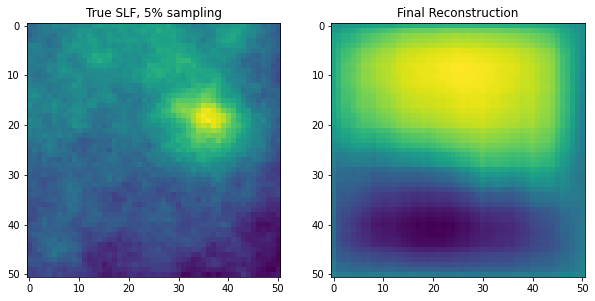

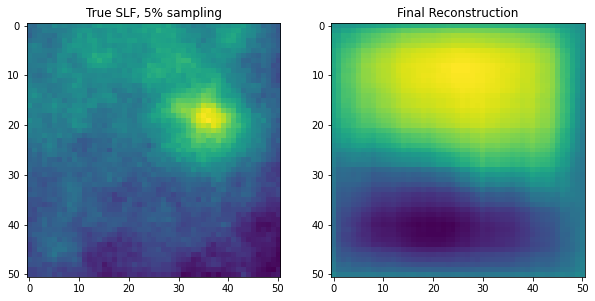

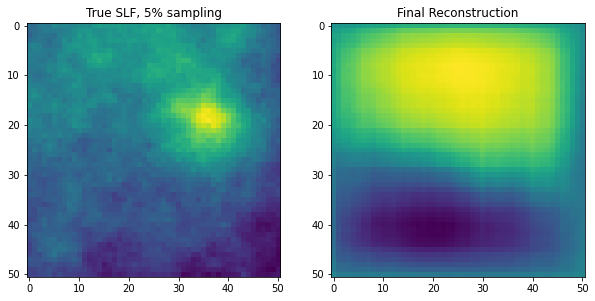

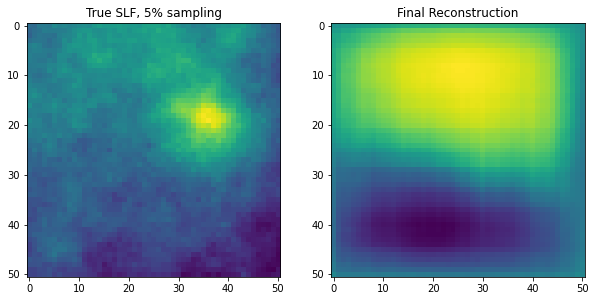

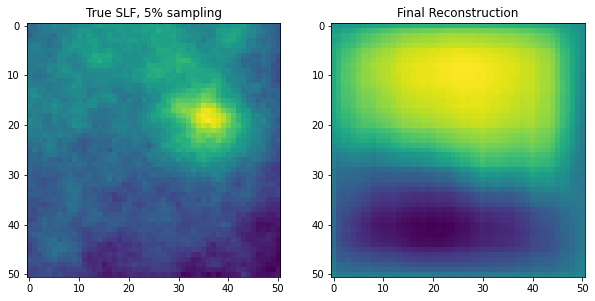

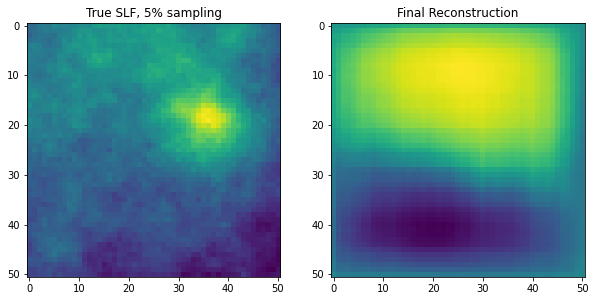

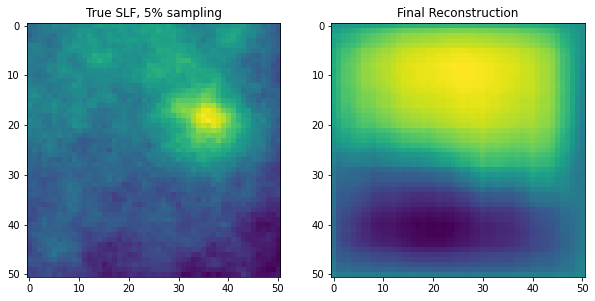

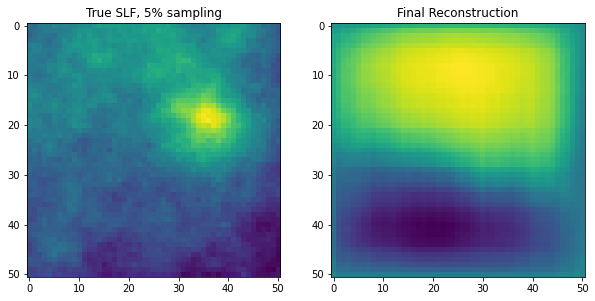

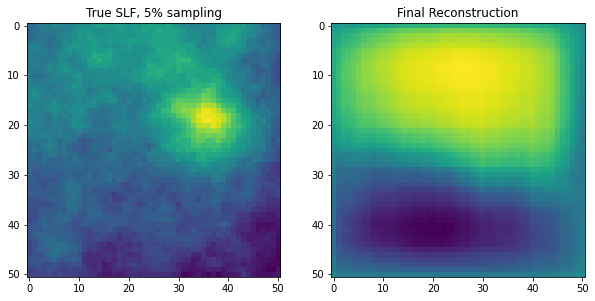

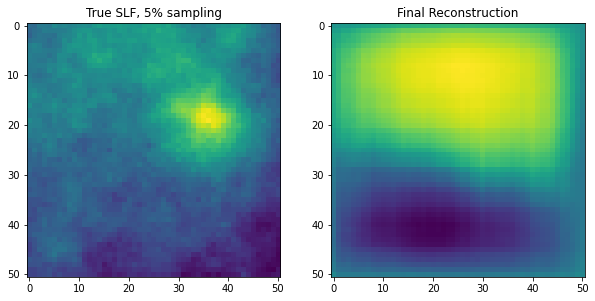

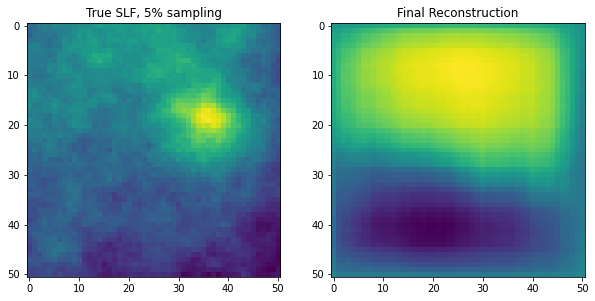

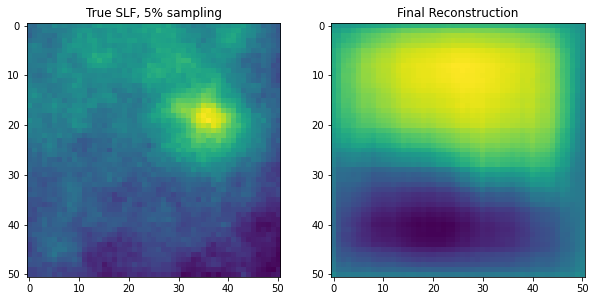

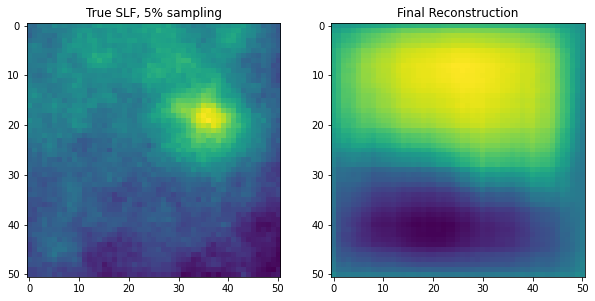

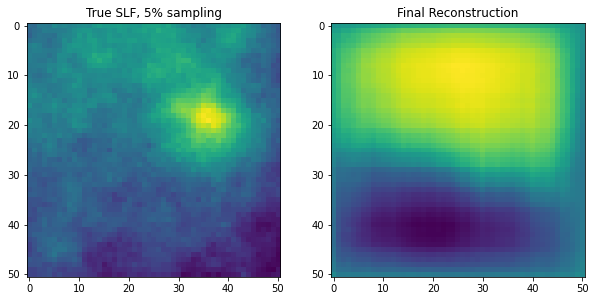

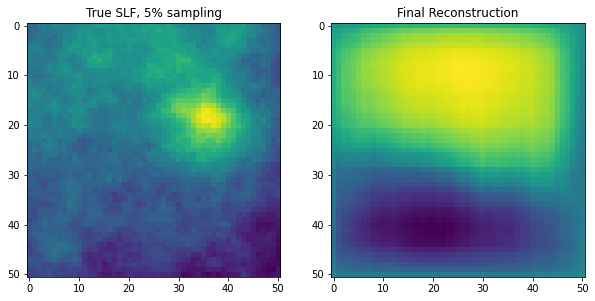

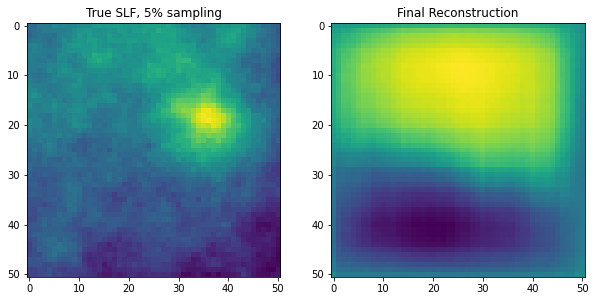

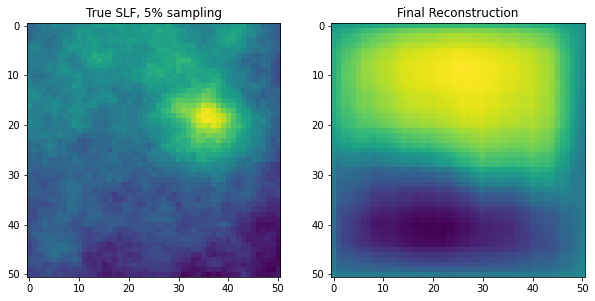

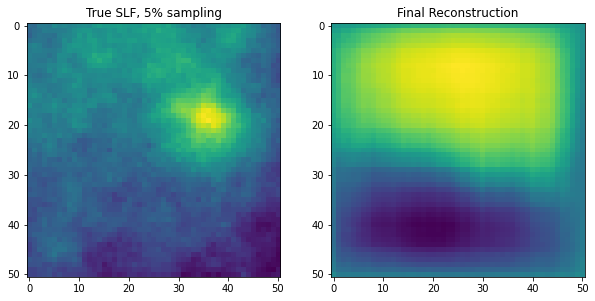

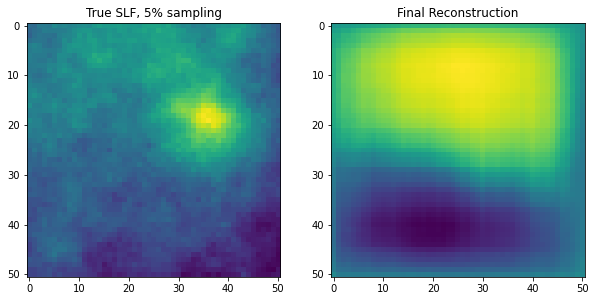

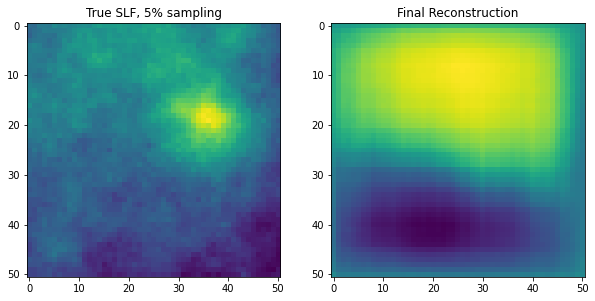

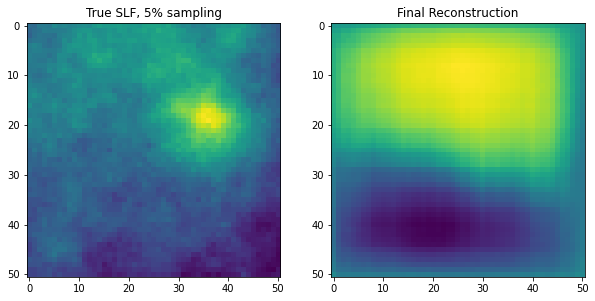

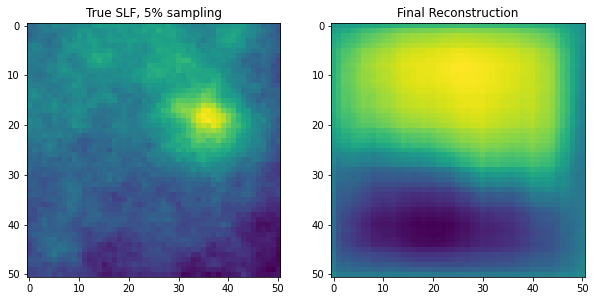

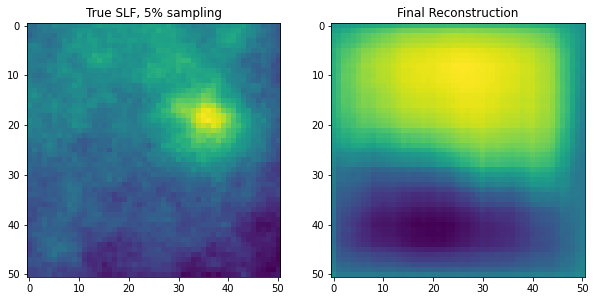

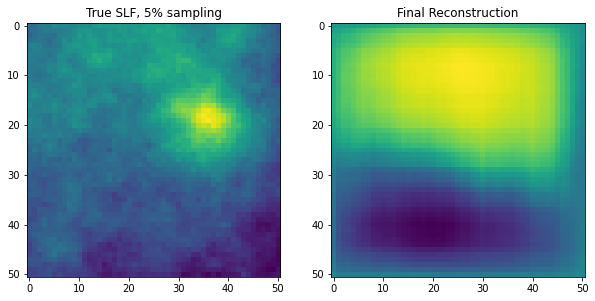

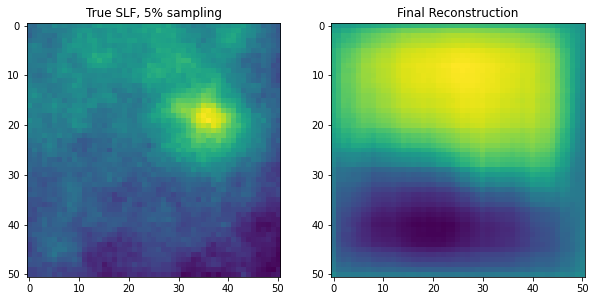

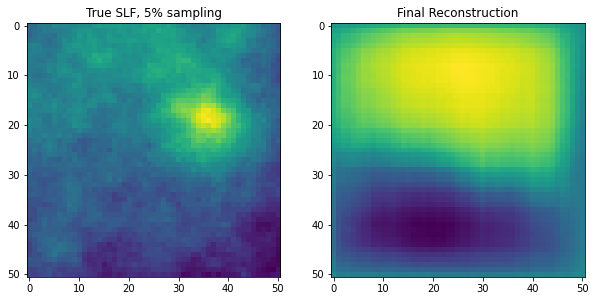

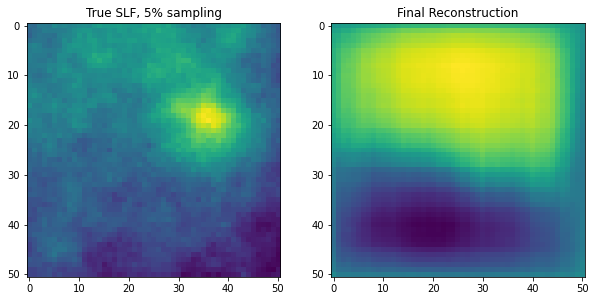

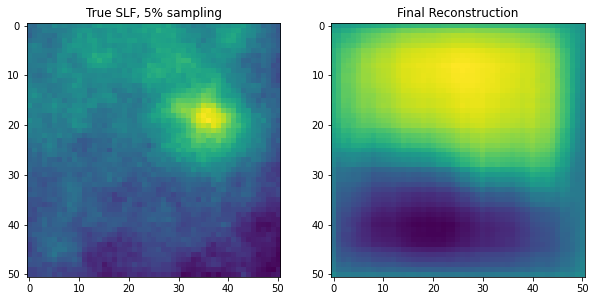

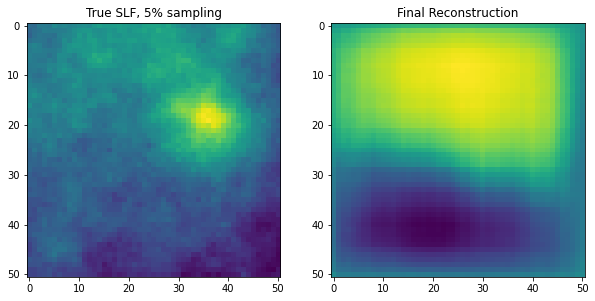

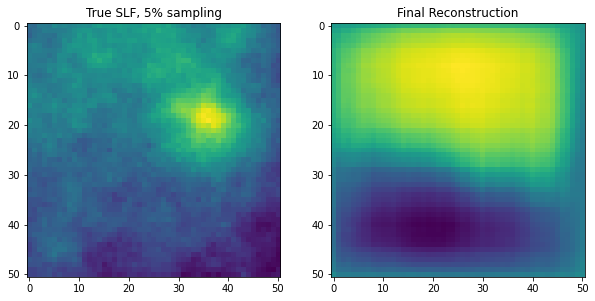

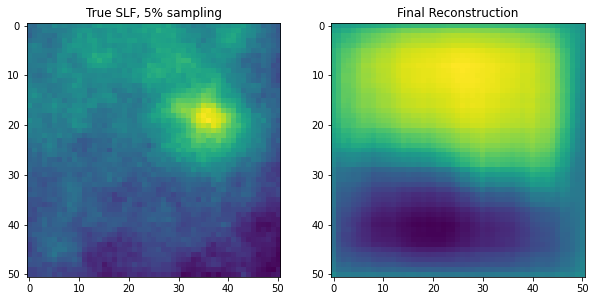

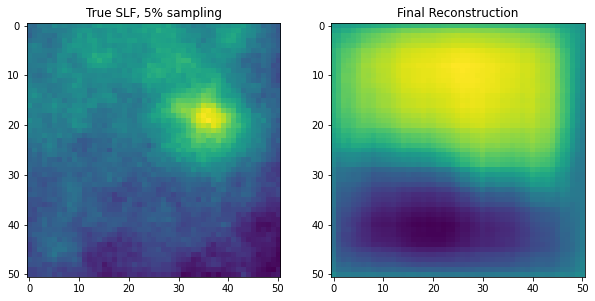

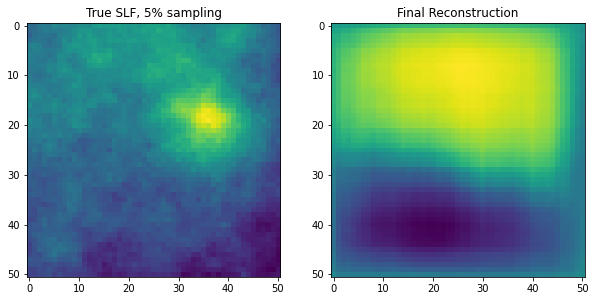

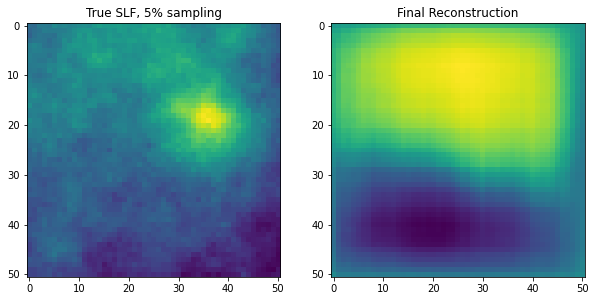

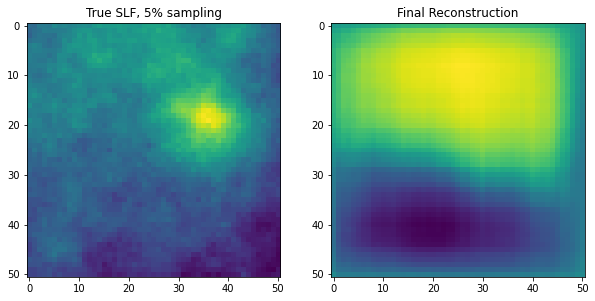

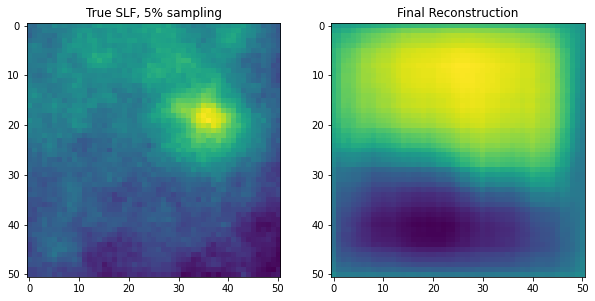

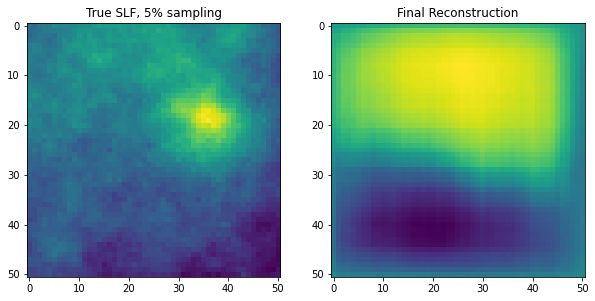

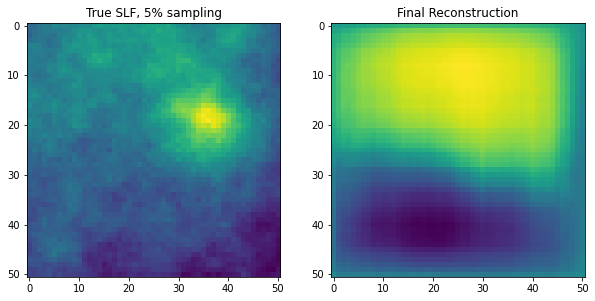

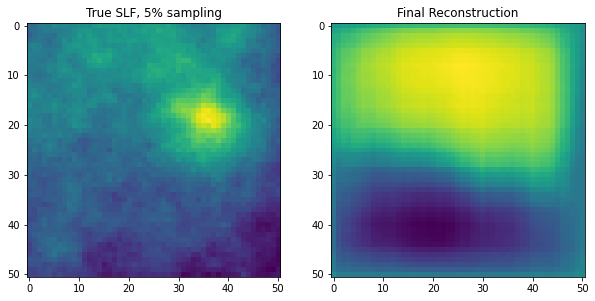

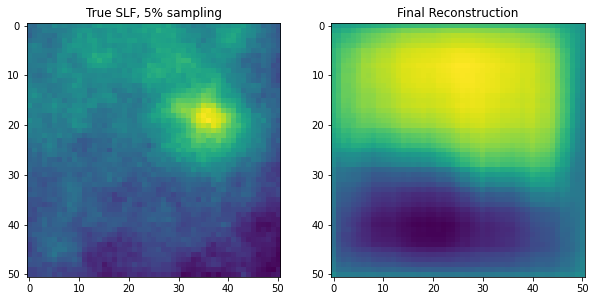

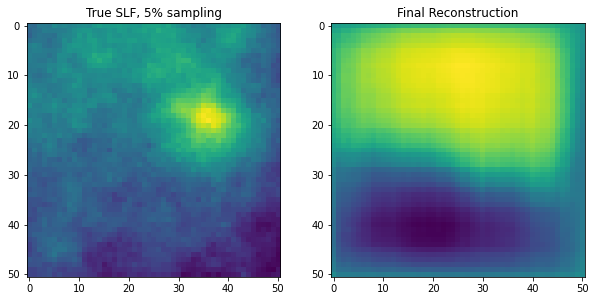

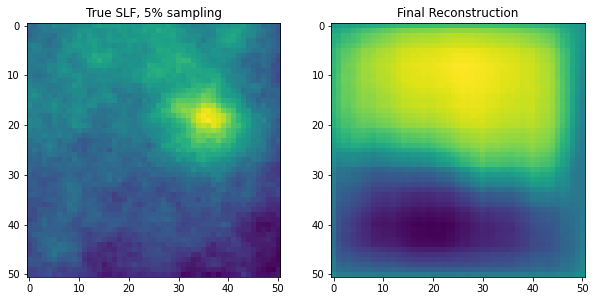

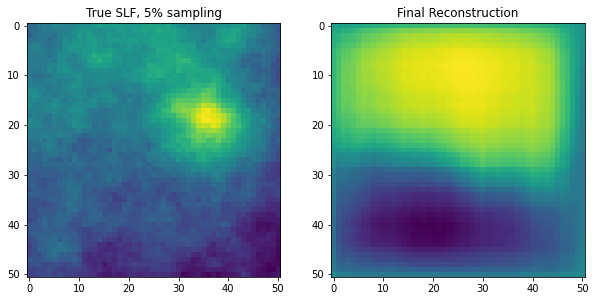

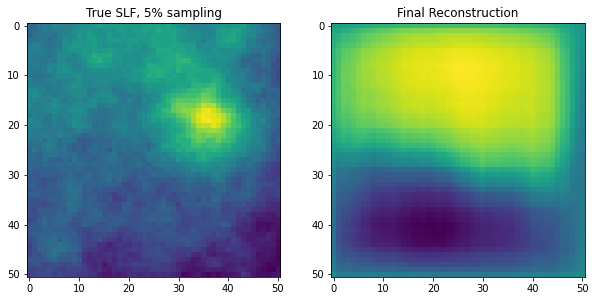

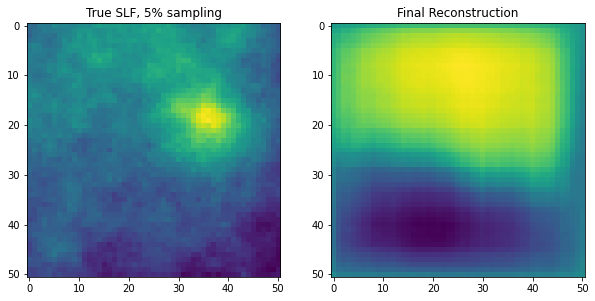

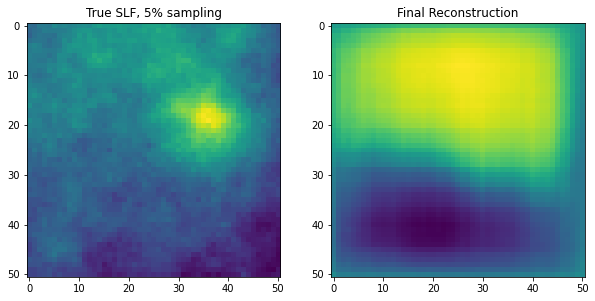

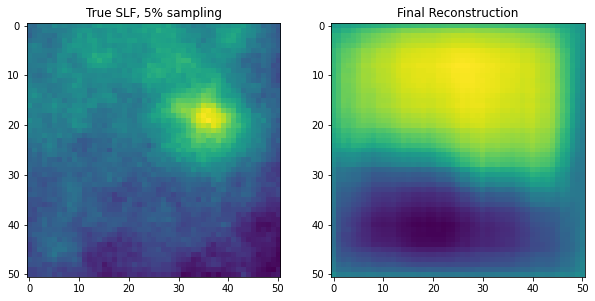

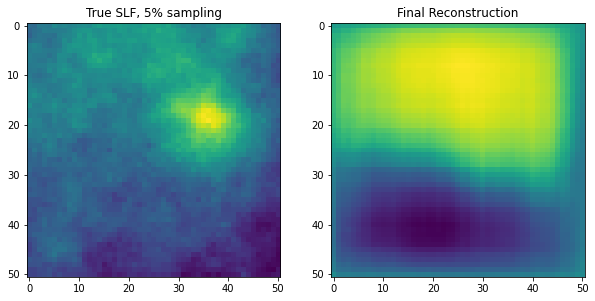

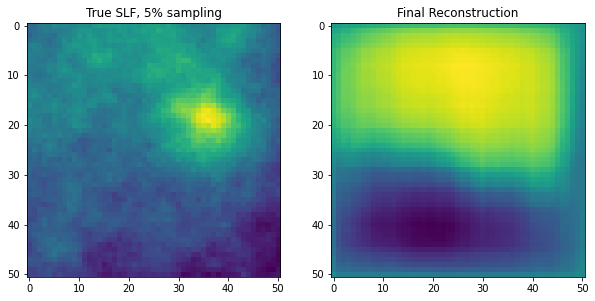

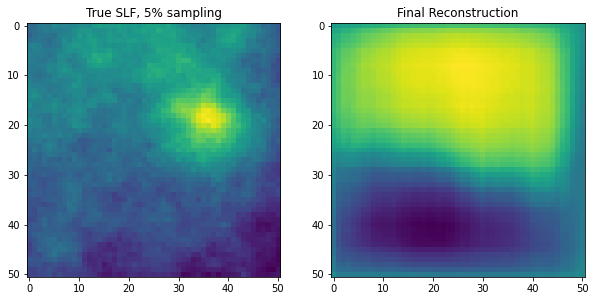

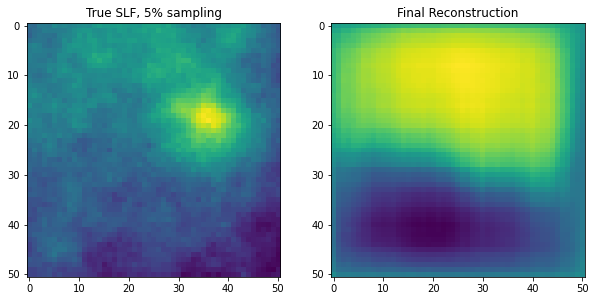

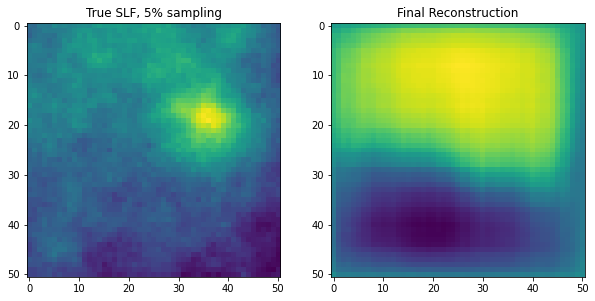

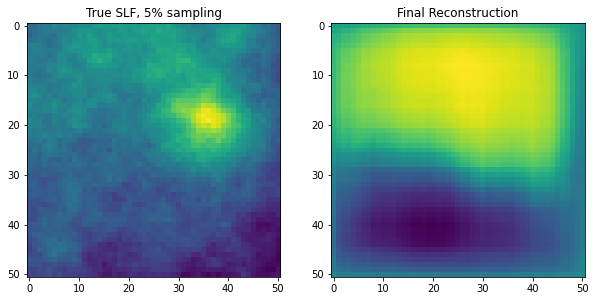

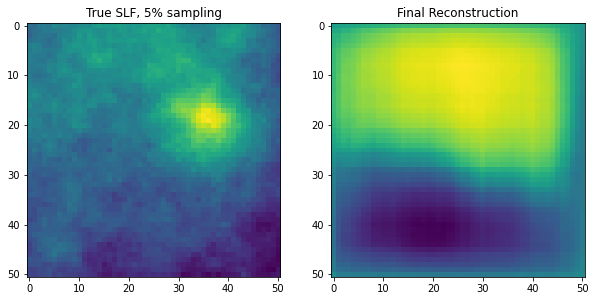

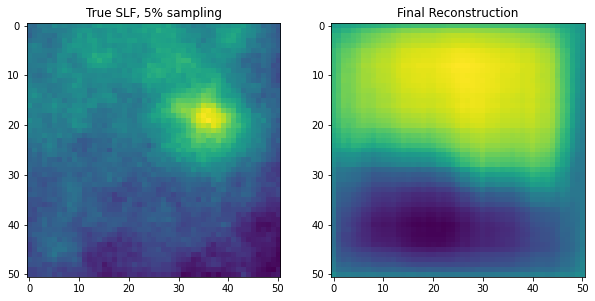

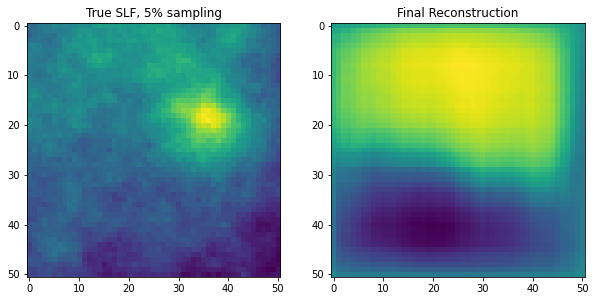

In [10]:
from slf_dataset import SLFDataset1bit, DEFAULT_ROOT
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy.io
import torch.nn as nn
import os
import sys
from networks.dip import DecoderDip

import scipy.io as sio
import torch
# observation
from utils import *
from quantization_model_log import *
from tqdm import trange
from IPython import display



SLF_ROOT = '/scratch/sagar/slf/train_set/set_harsh_torch_raw_unnormalized'

train_set_slf = SLFDataset1bit(root_dir=os.path.join(SLF_ROOT, 'slf_mat'), 
                    csv_file=os.path.join(SLF_ROOT, 'details.csv'), total_data=10000, sample_size=[0.1, 0.11])


data = sio.loadmat('../backup/data/onebitdata')

f = 0.1
std_probit = 0.008
# stds_probit = [0.00001, 0.0001, 0.001, 0.005, 0.008, 0.01, 0.02, 0.04]
stds_probit = [0.008]
nmse_list = []
lambda_s = 0.001
lambda_c = 0.001
loss_model = 'probit'  # one of 'sigmoid', 'probit', and 'determ'


S = torch.from_numpy(data['S']).type(torch.float32)
T = torch.from_numpy(data['T']).type(torch.float32)
C = torch.from_numpy(data['C']).type(torch.float32)
S_true = torch.from_numpy(data['S_true']).type(torch.float32)
C_true = torch.from_numpy(data['C_true']).type(torch.float32)
T_true = torch.from_numpy(data['T_true']).type(torch.float32)

Om = torch.from_numpy(data['Om']).type(torch.float32)
Om = torch.ones((64,1,51,51))*f
Om = torch.bernoulli(Om)

T = T.permute(2,0,1)
T_true = T_true.permute(2,0,1)

S = S.permute(2,0,1)
S_true = S_true.permute(2,0,1)

C = C.permute(1,0)
C_true = C_true.permute(1,0)

# W = Om.unsqueeze(dim=0)
# W = W.unsqueeze(dim=0)
# Wx = W.repeat(64,1,1,1)
Wx = Om

T_old = T.clone()
S_old = S.clone()


bin_boundaries = torch.tensor(QUANTIZATION_BOUNDARIES_7_ADJUSTED)
Y = quantize(S_true, std_probit, bin_boundaries, LOG_OFFSET_7_ADJUSTED)
Y = Y[0,:,:]

bin_boundaries = bin_boundaries/max(abs(bin_boundaries))
# parameters

z_dimension = 256
maxIter = 5000
R,I,J = S.shape
K = 64

T = T.unsqueeze(dim=1)

var_list = [SD_16_BINS_UNIFORM*2]
var_list = [1.5]

Z_init = torch.randn((1, 256))
generator = DecoderDip()
plot_iter = 30

nmses = np.zeros((len(var_list), maxIter))
costs = np.zeros((len(var_list), maxIter))
# costs = [[]]*len(var_list)


optimizerZ = torch.optim.SGD(generator.parameters(), lr=0.001)
generator.eval()

# Quantize and recover S

for var_id in range(len(var_list)):
    var = var_list[var_id]
    std_probit = var
    S_true_log = torch.log(S_true + LOG_OFFSET_7_ADJUSTED)
    S_true_log = S_true_log/(S_true_log.abs().max())
   
    Wx = Wx[0,0,:,:]
    
    for i in range(maxIter):
        S = generator(Z_init)
        optimizerZ.zero_grad()

        neg_log_likelihood = -torch.sum(Wx*prob_probit(Y, -S, bin_boundaries, std_probit))
        cost = neg_log_likelihood  + lambda_s*torch.norm(S, 'fro')

        cost.backward()
        optimizerZ.step()

        true_loss = torch.norm(S + S_true_log[0,:,:])

        nmses[var_id][i] = true_loss
        costs[var_id][i] = cost

        if i%plot_iter == 0:
            fig, ax = plt.subplots(1,2, figsize=(10, 5))

            ax[0].imshow((S_true_log[0,...]).squeeze().detach().numpy())
            ax[0].set_title('True SLF, 5% sampling')
            ax[1].imshow((-S[0,...]).squeeze().detach().numpy())
            ax[1].set_title('Final Reconstruction')

            display.clear_output(wait=True)
            display.display(plt.gcf())
    print('ended {}'.format(std_probit))
    nmse_list.append(true_loss)



In [63]:
S.shape

torch.Size([2, 1, 51, 51])

In [65]:
S

tensor([[[[0.5344, 0.5235, 0.5221,  ..., 0.5165, 0.5193, 0.5247],
          [0.5405, 0.5251, 0.5263,  ..., 0.5146, 0.5185, 0.5256],
          [0.5349, 0.5174, 0.5117,  ..., 0.5130, 0.5192, 0.5269],
          ...,
          [0.5390, 0.5158, 0.5141,  ..., 0.5164, 0.5187, 0.5318],
          [0.5467, 0.5267, 0.5250,  ..., 0.5146, 0.5154, 0.5290],
          [0.5514, 0.5366, 0.5352,  ..., 0.5360, 0.5339, 0.5394]]]],
       grad_fn=<SigmoidBackward>)

In [60]:
S

tensor([[[[0.4884, 0.4909, 0.4950,  ..., 0.4917, 0.4935, 0.4982],
          [0.4822, 0.4779, 0.4810,  ..., 0.4771, 0.4790, 0.4864],
          [0.4796, 0.4759, 0.4764,  ..., 0.4730, 0.4733, 0.4801],
          ...,
          [0.4895, 0.4880, 0.4809,  ..., 0.4837, 0.4890, 0.4900],
          [0.4922, 0.4909, 0.4866,  ..., 0.4803, 0.4880, 0.4889],
          [0.4962, 0.4924, 0.4904,  ..., 0.4811, 0.4886, 0.4872]]],


        [[[0.4847, 0.4886, 0.4904,  ..., 0.4892, 0.4953, 0.5012],
          [0.4771, 0.4769, 0.4778,  ..., 0.4777, 0.4837, 0.4945],
          [0.4762, 0.4749, 0.4758,  ..., 0.4691, 0.4783, 0.4901],
          ...,
          [0.4837, 0.4761, 0.4740,  ..., 0.4777, 0.4837, 0.4937],
          [0.4870, 0.4791, 0.4780,  ..., 0.4840, 0.4888, 0.4936],
          [0.4905, 0.4838, 0.4817,  ..., 0.4856, 0.4904, 0.4936]]]],
       grad_fn=<SigmoidBackward>)

In [56]:
S_true_log

tensor([[[-0.6067, -0.6105, -0.5697,  ..., -0.6000, -0.6309, -0.6535],
         [-0.6242, -0.5975, -0.5846,  ..., -0.5976, -0.6168, -0.6648],
         [-0.6355, -0.5955, -0.5771,  ..., -0.6107, -0.6306, -0.6562],
         ...,
         [-0.6821, -0.6806, -0.6759,  ..., -0.8515, -0.8470, -0.8497],
         [-0.7165, -0.7158, -0.6953,  ..., -0.8596, -0.8680, -0.8248],
         [-0.7134, -0.7183, -0.7035,  ..., -0.8440, -0.8270, -0.8174]],

        [[-0.7158, -0.7090, -0.6658,  ..., -0.8989, -0.8849, -0.8606],
         [-0.6906, -0.6778, -0.6818,  ..., -0.8710, -0.8785, -0.8798],
         [-0.6807, -0.6771, -0.6702,  ..., -0.9040, -0.8973, -0.8714],
         ...,
         [-0.6825, -0.6917, -0.6996,  ..., -0.9768, -0.9699, -0.9736],
         [-0.6714, -0.7037, -0.7042,  ..., -0.9589, -0.9685, -0.9605],
         [-0.6955, -0.6807, -0.7294,  ..., -0.9623, -0.9677, -0.9610]]])

In [57]:
bin_boundaries = bin_boundaries.clone()
# bin_boundaries[0] = -100000
# bin_boundaries[-1] = 100000

W = bin_boundaries[Y]
U = bin_boundaries[Y+1]

In [58]:
W

tensor([[-0.6225, -0.6225, -0.6225,  ..., -0.6225, -0.6225, -0.6809],
        [-0.6225, -0.6225, -0.6225,  ..., -0.6225, -0.6225, -0.6809],
        [-0.6225, -0.6225, -0.6225,  ..., -0.6225, -0.6225, -0.6809],
        ...,
        [-0.6809, -0.6809, -0.6809,  ..., -0.8753, -0.8753, -0.8753],
        [-0.7352, -0.7352, -0.6809,  ..., -0.8753, -0.8753, -0.8753],
        [-0.7352, -0.7352, -0.7352,  ..., -0.8753, -0.8753, -0.7942]])

In [59]:
U

tensor([[-0.5420, -0.5420, -0.5420,  ..., -0.5420, -0.5420, -0.6225],
        [-0.5420, -0.5420, -0.5420,  ..., -0.5420, -0.5420, -0.6225],
        [-0.5420, -0.5420, -0.5420,  ..., -0.5420, -0.5420, -0.6225],
        ...,
        [-0.6225, -0.6225, -0.6225,  ..., -0.7942, -0.7942, -0.7942],
        [-0.6809, -0.6809, -0.6225,  ..., -0.7942, -0.7942, -0.7942],
        [-0.6809, -0.6809, -0.6809,  ..., -0.7942, -0.7942, -0.7352]])

In [52]:
U

tensor([[-0.8753, -0.8753, -0.8753,  ..., -0.8753, -0.8753, -0.8753],
        [-0.8753, -0.8753, -0.8753,  ..., -0.8753, -0.8753, -0.8753],
        [-0.8753, -0.8753, -0.8753,  ..., -0.8753, -0.8753, -0.8753],
        ...,
        [-0.8753, -0.8753, -0.8753,  ..., -0.8753, -0.8753, -0.8753],
        [-0.8753, -0.8753, -0.8753,  ..., -0.8753, -0.8753, -0.8753],
        [-0.8753, -0.8753, -0.8753,  ..., -0.8753, -0.8753, -0.8753]])

In [24]:
S

tensor([[[[0.1799, 0.0911, 0.0585,  ..., 0.1121, 0.1670, 0.2662],
          [0.0890, 0.0258, 0.0115,  ..., 0.0335, 0.0661, 0.1517],
          [0.0509, 0.0099, 0.0035,  ..., 0.0154, 0.0385, 0.1110],
          ...,
          [0.0938, 0.0291, 0.0149,  ..., 0.0512, 0.0933, 0.1803],
          [0.1327, 0.0541, 0.0324,  ..., 0.0814, 0.1268, 0.2171],
          [0.2245, 0.1338, 0.0999,  ..., 0.1692, 0.2169, 0.3010]]],


        [[[0.1845, 0.0947, 0.0609,  ..., 0.1009, 0.1550, 0.2558],
          [0.0941, 0.0279, 0.0124,  ..., 0.0273, 0.0568, 0.1378],
          [0.0558, 0.0113, 0.0040,  ..., 0.0116, 0.0306, 0.0956],
          ...,
          [0.1113, 0.0385, 0.0200,  ..., 0.0866, 0.1302, 0.2152],
          [0.1486, 0.0646, 0.0385,  ..., 0.1262, 0.1703, 0.2526],
          [0.2402, 0.1482, 0.1110,  ..., 0.2193, 0.2580, 0.3262]]]],
       grad_fn=<SigmoidBackward>)

In [13]:
Y.shape

torch.Size([2, 51, 51])

In [12]:
Wx.shape

torch.Size([51, 51])

In [ ]:
W

torch.Size([64, 1, 51, 51])

torch.Size([2, 51, 51])

In [1]:
import utils
utils.__file__

'/scratch/sagar/Projects/matlab/quantized_spectrum_cartography/qmc/utils.py'

NameError: name 'SD_8_BINS_LOG' is not defined

In [ ]:
  

for var_id in range(len(var_list)):
    var = var_list[var_id]
    std_probit = var

    Y = quantize(T_true, std_probit, bin_boundaries, LOG_OFFSET)
    Y = Y.unsqueeze(dim=1)
    
    Z = Z_init.clone()

    Z = Z.detach().clone()
    C.requires_grad = True
    Z.requires_grad = True

    optimizerC = torch.optim.Adam([C], lr=0.005)
    optimizerZ = torch.optim.SGD(generator.parameters(), lr=0.001)
    generator.eval()
    
    with torch.no_grad():
        S = generator(Z)

    print("Initial nmse: {}".format(NMSE(get_tensor(generator(Z), C), T_true)))
    for i in trange(maxIter):
        # C optimization
        S = generator(Z)
        Sc = S.detach().clone()
        optimizerC.zero_grad()

        T_hat = get_tensor(Sc, C)
        T_hat = T_hat.unsqueeze(dim=1)
        T_hat = torch.log(T_hat+LOG_OFFSET_7_ADJUSTED)
        neg_log_likelihood = -torch.sum(Wx*torch.log(prob_probit(Y, T_hat, bin_boundaries, std_probit)))
        cost = neg_log_likelihood + lambda_c*torch.norm(C, 'fro') + lambda_s*torch.norm(S, 'fro')
        
        cost.backward()
        optimizerC.step()
        with torch.no_grad():
            C[C<0] = 0

#         true_loss = NMSE_LOG(get_tensor(S,C), T_true, LOG_OFFSET_7_ADJUSTED)
        
        true_loss = NMSE(get_tensor(S,C), T_true)
        nmses[var_id][i] = true_loss
        costs[var_id][i] = cost
        # S optimization
        optimizerZ.zero_grad()
        S = generator(Z)
        
        T_hat = get_tensor(S, C)
        T_hat = T_hat.unsqueeze(dim=1)
        T_hat = torch.log(T_hat+LOG_OFFSET_7_ADJUSTED)
        neg_log_likelihood = -torch.sum(Wx*torch.log(prob_probit(Y, T_hat, bin_boundaries, std_probit)))
        cost = neg_log_likelihood + lambda_c*torch.norm(C, 'fro') + lambda_s*torch.norm(S, 'fro')
        
        cost.backward()
        optimizerZ.step()

        true_loss = NMSE(get_tensor(S,C), T_true)
        nmses[var_id][i] = true_loss
        costs[var_id][i] = cost
        
        if i%plot_iter == 0:
            fig, ax = plt.subplots(2,3, figsize=(20,15))

            ax[0,0].imshow(torch.log(S_true[0,...]).squeeze().detach().numpy())
            ax[0,0].set_title('True SLF, 5% sampling')
            ax[1,0].imshow(torch.log(S[0,...]).squeeze().detach().numpy())
            ax[1,0].set_title('Final Reconstruction')

            ax[0,1].plot(C_true[0,:].detach().numpy())
            ax[0,1].set_title('True PSD')
            ax[1,1].plot(C[0,:].detach().numpy())
            ax[1,1].set_title('Final Reconstruction')


            ax[0,1].plot(C_true[1,:].detach().numpy())
            ax[0,1].set_title('True PSD')
            ax[1,1].plot(C[1,:].detach().numpy())
            ax[1,1].set_title('Final Reconstruction')

            k = 17
            T_hat = get_tensor(S, C)

            ax[0,2].imshow(torch.log(T_true[k,...]).squeeze().detach().numpy())
            ax[0,2].set_title('True Map')
            ax[1,2].imshow(torch.log(T_hat[k,...]).squeeze().detach().numpy())
            ax[1,2].set_title('Final Reconstruction')
            
            display.clear_output(wait=True)
            display.display(plt.gcf())
    print('ended {}'.format(std_probit))
    nmse_list.append(true_loss)

In [9]:
S

tensor([[[[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          ...,
          [1.9708e-27, 1.0412e-34, 1.0412e-34,  ..., 1.0412e-34,
           1.0412e-34, 3.0112e-27],
          [1.9708e-27, 1.0412e-34, 1.0412e-34,  ..., 1.0412e-34,
           1.0412e-34, 3.0112e-27],
          [2.9268e-22, 1.1793e-27, 1.1793e-27,  ..., 1.1793e-27,
           1.1793e-27, 7.5567e-22]]],


        [[[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          ...,
          [1.9708e-27, 1.0412e-34, 1.0412e-34,  ..., 1.04